In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/MS/ETAnalysis/Data/Tremor_eval_dl.zip" -d "./data"

# Setting

In [ ]:
import math, collections
from pathlib import Path
from typing import *
import os, re, math, json, gc, random, time, glob, warnings, itertools
import warnings
from tqdm import tqdm
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from dataclasses import dataclass
from functools import lru_cache

from scipy.signal import butter, filtfilt
from scipy.ndimage import median_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
_SPLIT_FILE_RE = re.compile(r".*_\d+_[123]$")  # 예: .../UniV_m_rawdata_0_1.csv (이미 분할된 파일 패턴)

def split_and_delete_multidirect_fs(
    root: Path = Path("/content/data"),
    *,
    c1_col: str = "c1",
    median_size: int = 5,
    suffix_map: Dict[int, str] = None,   # {100:"_1", 200:"_2", 300:"_3"}
    overwrite: bool = True
) -> dict:
    """
    /content/data 하위에서 디렉토리명이 'MultiDirect'(대소문자 무시)인 모든 CSV를 찾아:
      1) c1 전처리 (round → abs → median_filter(size=median_size) → ×100)
      2) c1=={100,200,300} 행을 각각 _1/_2/_3 접미사로 새 CSV 저장
      3) 분할본이 하나라도 생성되면 원본 CSV 삭제

    이미 분할된 파일(…_0_1.csv 등, 끝에 '_<trial>_<1|2|3>.csv')은 재처리/삭제 대상에서 제외.

    Returns
    -------
    {'saved': [...], 'deleted': [...], 'kept': [...], 'errors': [...]}
    """
    if suffix_map is None:
        suffix_map = {100: "_1", 200: "_2", 300: "_3"}

    # MultiDirect 디렉토리 하위의 모든 CSV 수집 (대소문자 무시)
    csv_files: List[Path] = [
        p for p in root.rglob("*.csv")
        if any(part.lower() == "multidirect" for part in p.parts)
    ]

    saved, deleted, kept, errors = [], [], [], []
    seen = set()

    for p in sorted(csv_files):
        if p in seen:
            continue
        seen.add(p)

        # 이미 분할된 파일 패턴이면 스킵 (…_trialLevel_c1Level.csv)
        if _SPLIT_FILE_RE.match(p.stem):
            kept.append(str(p))  # 그대로 유지
            continue

        # CSV 읽기
        try:
            df = pd.read_csv(p)
        except Exception as e:
            errors.append(f"[READ-ERROR] {p}: {e}")
            kept.append(str(p))
            continue

        if c1_col not in df.columns:
            errors.append(f"[MISSING-COLUMN] {p}: '{c1_col}' not found")
            kept.append(str(p))
            continue

        # c1 전처리: round → abs → median filter → ×100
        try:
            c1_raw = pd.to_numeric(df[c1_col], errors="coerce").to_numpy(dtype=float)
            c1_int = np.rint(c1_raw).astype(np.int64)
            c1_abs = np.abs(c1_int)
            c1_med = median_filter(c1_abs, size=median_size, mode="nearest").astype(np.int64)
            c1 = c1_med * 100  # 기대: {100,200,300}
        except Exception as e:
            errors.append(f"[C1-PROCESS-ERROR] {p}: {e}")
            kept.append(str(p))
            continue

        # 분할 저장
        wrote_any = False
        for lv, suf in suffix_map.items():
            m = (c1 == lv)
            if np.any(m):
                sub_df = df.loc[m].reset_index(drop=True)
                out_path = p.with_name(f"{p.stem}{suf}{p.suffix}")
                try:
                    if (not overwrite) and out_path.exists():
                        # 덮어쓰기 금지 시 존재하면 스킵
                        pass
                    else:
                        sub_df.to_csv(out_path, index=False)
                        saved.append(str(out_path))
                        wrote_any = True
                except Exception as e:
                    errors.append(f"[WRITE-ERROR] {out_path}: {e}")

        # 분할본이 하나라도 생겼다면 원본 삭제
        if wrote_any:
            try:
                p.unlink()
                deleted.append(str(p))
            except Exception as e:
                kept.append(str(p))
                errors.append(f"[DELETE-ERROR] {p}: {e}")
        else:
            kept.append(str(p))

    return {"saved": saved, "deleted": deleted, "kept": kept, "errors": errors}

split_and_delete_multidirect_fs(Path("/content/data"))

{'saved': ['/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_0_1.csv',
  '/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_0_2.csv',
  '/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_0_3.csv',
  '/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_1_1.csv',
  '/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_1_2.csv',
  '/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_1_3.csv',
  '/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_3_1.csv',
  '/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_3_2.csv',
  '/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_3_3.csv',
  '/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_4_1.csv',
  '/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_4_2.csv',
  '/content/data/ET01_1_01232017/MultiDirect/UniV_m_rawdata_4_3.csv',
  '/content/data/ET01_3_02062017/MultiDirect/UniV_m_rawdata_0_1.csv',
  '/content/data/ET01_3_02062017/MultiDirect/UniV_m_rawdata_0_2.csv',
  '/content

In [ ]:
ROOT = Path("/content/data")
OUT_DIR = Path("/content")
LABEL_DIR = Path('/content/drive/MyDrive/MS/ETAnalysis/Data/relabel_md_k5.csv')

SEED = 42
FS      = 100.0
SEG_LEN = 512
HOP     = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = 32
NUM_WORKERS = 4 if DEVICE == "cuda" else 2
USECOLS = ["accel_x","accel_y","accel_z","coor_x","coor_y"]
TARGET = 'target_k5'

_DIR_RE   = re.compile(r"ET(\d{2})_(\d)_(\d{8})")
_TASK_RE  = re.compile(r"(Spiral|Maze|MultiDirect)", re.IGNORECASE)

TASK2IDX = {"spiral": 0, "maze": 1, "multidirect": 2, "unknown": 3}


# ── 재현성 설정 ───────────────────────────────────────────
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Model

## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, in_c, hidden_size, num_layers, dropout=0.1):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=in_c,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )

    def forward(self, x):
        h_n, c_n = self.lstm(x)
        return h_n

    def encode(self, x):
        return self.forward(x)

## ResNet18

In [ ]:
class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(BasicBlock1D, self).__init__()
        # 수정사항 1. padding 자동 계산
        padding = (kernel_size - 1) // 2

        self.conv1 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1,
            padding=padding,
            bias=False
        )
        self.bn2 = nn.BatchNorm1d(out_channels)
        # shortcut
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        # 수정사항 2. ReLU 모듈화
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out_main = self.conv1(x)
        out_main = self.bn1(out_main)
        out_main = self.relu(out_main)
        out_main = self.conv2(out_main)
        out_main = self.bn2(out_main)

        out_sc = self.shortcut(x)

        y = self.relu(out_main + out_sc)
        return y


class ResNet18_1D(nn.Module):
    def __init__(self, num_classes, input_channels, d_model):
        super(ResNet18_1D, self).__init__()

        self.stem = nn.Sequential(
            nn.Conv1d(
                in_channels=input_channels,
                out_channels=64,
                kernel_size=7,
                stride=2,
                padding=3,
                bias=False
            ),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_stage(64, 64, [1, 1])
        self.stage2 = self._make_stage(64, 128, [2, 1])
        self.stage3 = self._make_stage(128, 256, [2, 1])
        self.stage4 = self._make_stage(256, 512, [2, 1])

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(output_size=1),
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

        self.proj = nn.Conv1d(
            in_channels=512,
            out_channels=d_model,
            kernel_size=1,
            stride=1,
            bias=False,
        )
        self.apply(self._initialize_weights)

    def _make_stage(self, in_channels, out_channels, strides: list):
        layers = []
        for s in strides:
            layers.append(
                BasicBlock1D(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=s
                )
            )
            in_channels = out_channels
        return nn.Sequential(*layers)

    def _initialize_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.head(x)
        return x

    def encode(self, x):
        x = x.permute(0, 2, 1)
        x = self.stem(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.proj(x)

        return x.permute(0, 2, 1)

## TimesNet

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super().__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super().__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x)


class Inception_Block_V1(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=6, init_weight=True):
        super(Inception_Block_V1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels
        kernels = []
        for i in range(self.num_kernels):
            kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=2 * i + 1, padding=i))
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels):
            res_list.append(self.kernels[i](x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res

class Inception_Block_V2(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=7, init_weight=True):
        super(Inception_Block_V2, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels
        kernels = []
        for i in range(self.num_kernels // 2):
            kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=[1, 2 * i + 3], padding=[0, i + 1]))
            kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=[2 * i + 3, 1], padding=[i + 1, 0]))
        kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=1))
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels // 2 * 2 + 1):
            res_list.append(self.kernels[i](x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res


def FFT_for_Period(x, k=2, fs=100.0, f_min=None):
    B, T, C = x.shape
    xf = torch.fft.rfft(x, dim=1)
    frequency_list = abs(xf).mean(0).mean(-1)

    if f_min is None:
        frequency_list[0] = 0
    else:
        # Zero-out all components ≤ f_min (including DC)
        idx_cut = int(math.floor(float(f_min) * T / float(fs)))   # bin index for f_min
        frequency_list[:idx_cut + 1] = 0

    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]


class TimesBlock(nn.Module):
    def __init__(self, seq_len, d_model, d_ff, top_k, f_min=None):
        super().__init__()
        self.seq_len = seq_len
        self.k = top_k
        self.f_min = f_min

        self.conv = nn.Sequential(
            Inception_Block_V2(d_model, d_ff),
            nn.GELU(),
            Inception_Block_V2(d_ff, d_model),
        )

    def forward(self, x):
        B, T, N = x.size()
        # period_list, period_weight = FFT_for_Period(x, k=self.k, f_min=self.f_min)
        period_list, period_weight = FFT_for_Period(x, k=self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if self.seq_len % period != 0:
                length = ((self.seq_len // period) + 1) * period
                padding = torch.zeros([x.shape[0], (length - self.seq_len), x.shape[2]]).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = self.seq_len
                out = x
            # reshape
            out = out.reshape(B, length // period, period, N).permute(0, 3, 1, 2).contiguous()
            # 2D conv
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1 ,N)
            res.append(out[:, :self.seq_len, :])
        res = torch.stack(res, dim=-1) # B T N k
        # adaptive aggregation
        period_weight = F.softmax(period_weight, dim=-1)
        period_weight = period_weight.unsqueeze(
            1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        # residual connection
        res = res + x
        return res


class TimesNet(nn.Module):
    def __init__(self, num_class, seq_len, enc_in, d_model, d_ff, e_layers, top_k, f_min=None, dropout=0.1):
        super().__init__()
        self.enc_embedding = DataEmbedding(enc_in, d_model, dropout)
        self.model = nn.ModuleList([TimesBlock(seq_len, d_model, d_ff, top_k, f_min)
                                    for _ in range(e_layers)])
        self.layer = e_layers
        self.layer_norm = nn.LayerNorm(d_model)
        self.act = F.gelu
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Linear(d_model * seq_len, num_class)
        self.d_model = d_model
        self.seq_len = seq_len
        self.num_class = num_class

    # ===== 추가: 세그먼트 임베딩만 뽑는 메서드 =====
    def encode(self, x_enc):  # x_enc: [B, T, C]
        enc_out = self.enc_embedding(x_enc)  # [B,T,d_model]
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))
        # y = self.act(enc_out)
        # y = self.dropout(y)
        # # 간단하고 안정적인 통계 풀링(평균). 필요하면 mean+std concat으로 확장 가능.
        # feat = y.mean(dim=1)                  # [B, d_model]
        return enc_out

    # 기존 세그먼트 단일 분류도 유지
    def classification(self, x):
        enc_out = self.enc_embedding(x)
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))
        output = self.act(enc_out)
        output = self.dropout(output)
        output = output.reshape(output.shape[0], -1)
        return self.projection(output)

    def forward(self, x):
        return self.classification(x)  # [B, num_class]

## MyWaveNet

In [ ]:
class AttnPoolHead(nn.Module):
    def __init__(self, d_model, num_class, p=0.1):
        super().__init__()
        self.score = nn.Linear(d_model, 1, bias=False)
        self.proj = nn.Sequential(
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(d_model, num_class)
        )

    def forward(self, x):
        # x = B T D
        s = self.score(x).squeeze(-1) # B T
        w = F.softmax(s, dim=1) # B T
        z = torch.einsum('bt,btd->bd', w, x) # B d
        return self.proj(z)

class _GatedResidualUnit(nn.Module):
    def __init__(self, res_ch, skip_ch, dilation):
        super().__init__()
        self.conv_filter = nn.Conv1d(res_ch, res_ch, 2,
                                     padding=dilation, dilation=dilation)
        self.conv_gate   = nn.Conv1d(res_ch, res_ch, 2,
                                     padding=dilation, dilation=dilation)
        self.conv_res    = nn.Conv1d(res_ch, res_ch, 1)
        self.conv_skip   = nn.Conv1d(res_ch, skip_ch, 1)

    def forward(self, x):
        # causal padding 보정 (Conv1d 는 causal 지원 X → 수동 crop)
        out_f = self.conv_filter(x)[:, :, :-self.conv_filter.dilation[0]]
        out_g = self.conv_gate  (x)[:, :, :-self.conv_gate.dilation[0]]
        z = torch.tanh(out_f) * torch.sigmoid(out_g)          # gated
        res = self.conv_res(z)
        skip= self.conv_skip(z)
        return (x + res), skip


class MyWaveNet(nn.Module):
    def __init__(
            self,
            in_ch: int,
            res_ch: int,
            skip_ch: int,
            dilations: list,
            n_classes: int = 4,
            n_stacks: int = 2,
    ):
        super().__init__()

        self.skip_ch = skip_ch

        self.ln_pre_cls = nn.LayerNorm(skip_ch)

        self.input_proj = nn.Conv1d(in_ch, res_ch, kernel_size=1)

        def _stack_blocks(nstacks: int, dilations_list, block_cls, res_ch, skip_ch):
            blocks = []
            for _ in range(nstacks):
                for d in dilations_list:
                    blocks.append(block_cls(res_ch, skip_ch, d))
            return nn.ModuleList(blocks)

        self.res_blocks = _stack_blocks(n_stacks, dilations, _GatedResidualUnit, res_ch, skip_ch)

        self.cls_head = AttnPoolHead(skip_ch, n_classes)

    def encode(self, x):
        x = x.permute(0, 2, 1) # B T C -> B C T
        x = self.input_proj(x)

        skip_sum = None
        for blk in self.res_blocks:
            x, skip = blk(x)
            skip_sum = skip if skip_sum is None else skip_sum + skip

        return skip_sum.permute(0, 2, 1) # B T C

    def forward(self, x):
        # x : B C T
        skip_sum = self.encode(x)

        skip_sum = self.ln_pre_cls(skip_sum) # B T C

        logits_global = self.cls_head(skip_sum)             # (B, n_classes)

        return logits_global

## MIL_MultiModal

In [ ]:
class GAPTimeReadout(nn.Module):
    """
    x: [B*, T, D] -> z: [B*, D]  (시간축 평균)
    """
    def __init__(self, p: float = 0.0):
        super().__init__()
        self.drop = nn.Dropout(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = x.mean(dim=1)  # [B*, D]
        return self.drop(z)

class AttnTimeReadout(nn.Module):
    """
    x: [B*, T, D] → (z: [B*, D], w_time: [B*, T])
    """
    def __init__(self, d_model: int, p: float = 0.1):
        super().__init__()
        self.score = nn.Linear(d_model, 1, bias=False)
        self.drop = nn.Dropout(p)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        s = self.score(x).squeeze(-1)          # [B*, T]
        w = F.softmax(s, dim=1)                # [B*, T]
        z = torch.einsum('bt,btd->bd', w, x)   # [B*, D]
        return self.drop(z), w

# ─────────────────────────────────────────────
# 인스턴스 수준 → bag 수준으로 집계하는 Gated Attention MIL
# (Ilse et al., 2018 스타일)
# ─────────────────────────────────────────────
class AttnMILHead(nn.Module):
    """
    feats: [B, N, D], mask: [B, N] (True=valid)
    반환: logits: [B, C], alpha_inst: [B, N]
    """
    def __init__(self, feat_dim: int, num_classes: int, attn_dim: int = 128, dropout: float = 0.1):
        super().__init__()
        self.V = nn.Linear(feat_dim, attn_dim)
        self.U = nn.Linear(feat_dim, attn_dim)
        self.w = nn.Linear(attn_dim, 1)
        self.drop = nn.Dropout(dropout)
        self.classifier = nn.Linear(feat_dim, num_classes)

    def forward(self, feats: torch.Tensor, mask: Optional[torch.Tensor] = None):
        B, N, D = feats.shape
        Vh = torch.tanh(self.V(feats))               # [B,N,A]
        Uh = torch.sigmoid(self.U(feats))            # [B,N,A]
        A  = self.w(self.drop(Vh * Uh)).squeeze(-1)  # [B,N]
        if mask is not None:
            A = A.masked_fill(~mask, float('-inf'))
        alpha = torch.softmax(A, dim=1)              # [B,N]
        z = torch.einsum('bn,bnd->bd', alpha, feats) # [B,D]
        logits = self.classifier(self.drop(z))       # [B,C]
        return logits, alpha


class MIL_MultiModalTimesNet(nn.Module):
    """
    입력:
      x_acc_bag  : [B, N, T, C_acc]
      x_traj_bag : [B, N, T, C_traj]
      mask       : [B, N] (True=valid)

    출력:
      sev_logits : [B, num_sclass]
      task_logits: [B, num_tclass]
      aux        : dict (해석용 가중치들)
    """
    def __init__(
        self,
        acc_encoder, traj_encoder,
        d_model: int,
        num_sclass: int,
        *,
        ma_heads: int = 2,
        ma_dropout: float = 0.1,
        time_dropout: float = 0.1,
        mil_attn_dim: int = 64,
        time_pool : str = 'attn',
    ):
        super().__init__()
        self.acc_encoder = acc_encoder
        self.traj_encoder = traj_encoder

        self.acc_ln  = nn.LayerNorm(d_model)
        self.traj_ln = nn.LayerNorm(d_model)

        self.ma = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=ma_heads, dropout=ma_dropout, batch_first=True
        )

        self.time_pool = time_pool
        if self.time_pool == "attn":
        # 시간축 readout (인스턴스 임베딩 만들기)
            self.time_readout_sev  = AttnTimeReadout(d_model, p=time_dropout)  # attn_output → z_sev_inst
        elif self.time_pool == 'gap':
            self.time_readout_sev = GAPTimeReadout(p=time_dropout)
        # 인스턴스→bag MIL (집계 후 최종 로짓)
        self.mil_sev  = AttnMILHead(feat_dim=d_model, num_classes=num_sclass, attn_dim=mil_attn_dim, dropout=ma_dropout)

    @torch.no_grad()
    def _check_shapes(self, x_acc_bag, x_traj_bag, mask):
        assert x_acc_bag.dim() == 4 and x_traj_bag.dim() == 4, "x_* shape must be [B,N,T,C]"
        assert x_acc_bag.shape[:3] == x_traj_bag.shape[:3], "ACC/TRAJ must share [B,N,T]"
        if mask is not None:
            assert mask.shape == x_acc_bag.shape[:2], "mask shape must be [B,N]"

    def forward(self, x_acc_bag: torch.Tensor, x_traj_bag: torch.Tensor, mask: Optional[torch.Tensor] = None):
        self._check_shapes(x_acc_bag, x_traj_bag, mask)
        B, N, T, C_acc = x_acc_bag.shape
        _, _, _, C_traj = x_traj_bag.shape

        # ── (1) 인스턴스 펼치기 ─────────────────────────────────────
        x_acc  = x_acc_bag.reshape(B*N, T, C_acc)      # [B*N, T, C_acc]
        x_traj = x_traj_bag.reshape(B*N, T, C_traj)    # [B*N, T, C_traj]

        # ── (2) 인코더: 시계열 → 시퀀스 임베딩 ─────────────────────
        y_acc  = self.acc_encoder.encode(x_acc)          # [B*N, T, D]
        y_traj = self.traj_encoder.encode(x_traj)      # [B*N, T, D]

        y_acc = self.acc_ln(y_acc)
        y_traj = self.traj_ln(y_traj)

        # ── (3) Cross-Attention: acc(query) ← traj(key/value) ─────
        attn_output, attn_w = self.ma(y_traj, y_acc, y_acc)  # [B*N, T, D], [B*N, num_heads, T, T] (batch_first=True)

        # ── (4) 시간축 어텐션 풀링(인스턴스 임베딩) ─────────────────
        if self.time_pool == "attn":
            z_sev_inst,   w_time_sev  = self.time_readout_sev(attn_output) # [B*N, D], [B*N, T]
        elif self.time_pool == 'gap':
            z_sev_inst = self.time_readout_sev(attn_output) # [B*N, D]
            w_time_sev = None

        # ── (5) [B,N,D]로 재구성 ───────────────────────────────────
        D = z_sev_inst.shape[-1]
        feats_sev  = z_sev_inst.view(B, N, D)    # [B,N,D]

        # ── (6) MIL 집계 (인스턴스 → bag) ──────────────────────────
        sev_logits,  alpha_inst_sev  = self.mil_sev(feats_sev,  mask)  # [B,S], [B,N]
        L = w_time_sev.shape[1] if self.time_pool == "attn" else None
        # 해석용 가중치 (시간/인스턴스)
        aux = {
            "alpha_inst_sev":  alpha_inst_sev,                     # [B,N]
            "w_time_sev":  None if w_time_sev is None else w_time_sev.view(B, N, L),               # [B,N,T]
        }
        return sev_logits, aux

## MIL_Single

In [ ]:
class MIL_Single(nn.Module):
    def __init__(
        self,
        base_encoder: nn.Module,
        num_classes: int,
        *,
        d_model: int = 128,
        time_dropout: float = 0.1,
        attn_dim: int = 128,
        mil_dropout: float = 0.1,
    ):
        super().__init__()
        self.encoder = base_encoder
        self.time_readout = AttnTimeReadout(d_model=d_model, p=time_dropout)  # x:[B*,T,D]
        self.mil_head = AttnMILHead(feat_dim=d_model, num_classes=num_classes,
                                    attn_dim=attn_dim, dropout=mil_dropout)

    def encode_instances(self, x_bag: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        x_bag: [B, N, T, C]
        return:
          z_inst: [B, N, D]
          w_time: [B, N, T]
        """
        B, N, T, C = x_bag.shape
        x_flat = x_bag.reshape(B * N, T, C)
        feat_map = self.encoder.encode(x_flat)
        z_flat, w_flat = self.time_readout(feat_map)  # [B*N, D], [B*N, T]

        T_enc = w_flat.size(-1)         # ★ 인코더가 만든 실제 시간 길이
        D = z_flat.size(-1)             # 임베딩 차원
        # bag 차원 복원
        z_inst = z_flat.view(B, N, -1)    # [B, N, D]
        w_time = w_flat.view(B, N, T_enc)     # [B, N, T]
        return z_inst, w_time

    def forward(
        self,
        x_bag: torch.Tensor,                 # [B, N, T, C]
        mask: Optional[torch.Tensor] = None  # [B, N] (True=valid)
    ):
        z_inst, w_time = self.encode_instances(x_bag)          # [B,N,D], [B,N,T]
        logits_bag, alpha_inst = self.mil_head(z_inst, mask)   # [B,C], [B,N]
        return logits_bag, alpha_inst, w_time

# Dataset

## build manifest

In [ ]:
def build_manifest(
    label_csv_path: Path,
    root_dir: Path,                  # 절대경로가 이미 들어있지만 인터페이스는 유지
    *,
    target_col = 'target',
    require_exists: bool = True,     # True면 실제 파일 존재하는 행만 남김
) -> pd.DataFrame:

    df = pd.read_csv(label_csv_path)

    required = {"file", "patient_id", "session", "task", target_col}
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f"다음 컬럼이 필요합니다: {missing}")

    rows = []
    for _, r in tqdm(df.iterrows(), total=len(df), desc="Build manifest (K=3)", unit="row"):
        # 1) 경로
        raw_file = str(r["file"]).strip()
        if not raw_file or raw_file.lower() == "nan":
            continue
        p = Path(raw_file)
        if not p.is_absolute():
            p = (root_dir / p).resolve()
        if require_exists and not p.exists():
            continue

        # 2) target (정수)
        try:
            target = int(r[target_col])
        except Exception:
            target = int(float(r[target_col]))

        # 3) patient_id: 'ET01' -> 1
        pid_match = re.search(r"(\d+)", str(r["patient_id"]))
        patient_id = int(pid_match.group(1)) if pid_match else -1

        # 4) session, date: 'ET01_1_01232017' → session=1, date='01232017'
        sess_str = str(r["session"])
        m = _DIR_RE.search(sess_str) or _DIR_RE.search(str(p))
        if m:
            session = int(m.group(2))
            date = m.group(3)
        else:
            session = -1
            date = "00000000"

        # 5) task & task_idx
        task = str(r["task"])
        task_idx = TASK2IDX.get(task.lower(), TASK2IDX["unknown"])

        rows.append(dict(
            path=p,
            patient_id=patient_id,
            session=session,
            date=date,
            task=task,
            task_idx=task_idx,
            target=target,
        ))

    man = pd.DataFrame(rows)
    if len(man):
        # [수정됨] target 컬럼이 0-based가 되도록 조정
        min_target = man["target"].min()
        if min_target > 0:
            man["target"] = man["target"] - min_target

        man = man.sort_values(["patient_id","session","task","path"]).reset_index(drop=True)
        man["target"] = man["target"].astype(int)
    return man


def split_train_valid_by_patient(
    manifest_df: pd.DataFrame,
    val_pid: Sequence[int],
    *,
    pid_col: str = "patient_id",
    reset_index: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    manifest 형태의 DataFrame을 받아, val_pid에 포함된 환자는 valid_df로,
    나머지는 train_df로 분리하여 반환합니다.

    Parameters
    ----------
    manifest_df : pd.DataFrame
        'patient_id' 컬럼(기본값)을 포함한 manifest 데이터프레임.
    val_pid : Sequence[int]
        검증 셋에 넣을 환자 번호 리스트. 예) [2, 5, 9]
    pid_col : str, default 'patient_id'
        환자 ID가 들어있는 컬럼명.
    reset_index : bool, default True
        반환하는 데이터프레임의 인덱스를 0부터 재설정할지 여부.

    Returns
    -------
    train_df : pd.DataFrame
        val_pid에 속하지 않는 환자들의 샘플.
    valid_df : pd.DataFrame
        val_pid에 속하는 환자들의 샘플.
    """
    if pid_col not in manifest_df.columns:
        raise KeyError(f"'{pid_col}' 컬럼이 없습니다. 현재 컬럼: {list(manifest_df.columns)}")

    # 숫자형으로 안전 변환 (NaN은 검증 집합에 포함되지 않음)
    pid_series = pd.to_numeric(manifest_df[pid_col], errors="coerce")
    val_set = set(int(x) for x in val_pid)

    valid_mask = pid_series.isin(val_set)
    valid_df = manifest_df.loc[valid_mask].copy()
    train_df = manifest_df.loc[~valid_mask].copy()

    if reset_index:
        valid_df.reset_index(drop=True, inplace=True)
        train_df.reset_index(drop=True, inplace=True)

    return train_df, valid_df

def build_segment_manifest(
    manifest_df: pd.DataFrame,
    *,
    seg_len: int,
    hop: int,
    usecols: Sequence[str] = ("accel_x","accel_y","accel_z","coor_x","coor_y"),
    require_exists: bool = True,
    keep_tail: bool = False,   # 마지막 남는 길이를 버리지 않고 패딩해 포함하고 싶으면 True (패딩은 하지 않고 end=T로만 기록)
) -> pd.DataFrame:
    """
    Parameters
    ----------
    manifest_df : pd.DataFrame
        build_manifest() 결과. 필수 컬럼:
        ['path','patient_id','session','date','task','task_idx','target']
    seg_len : int
        세그먼트 길이(샘플 수)
    hop : int
        홉(겹침). 0 또는 음수면 seg_len으로 간주(오버랩 없음)
    usecols : Sequence[str]
        CSV에서 길이 확인을 위해 읽을 컬럼(존재하는 것만 사용)
    require_exists : bool
        True면 파일이 실제로 있는 행만 처리
    keep_tail : bool
        True면 (T - seg_len) % hop 잔여가 있을 때 마지막 구간을 하나 더 만듦
        (end는 T로 기록; 모델 입력에서 패딩은 사용자가 처리)

    Returns
    -------
    seg_manifest : pd.DataFrame
        컬럼: ['path','patient_id','session','date','task','task_idx','target','start','end','seg_idx']
    """
    required = {"path","patient_id","session","date","task","task_idx","target"}
    missing = required - set(manifest_df.columns)
    if missing:
        raise KeyError(f"다음 컬럼이 필요합니다: {missing}")

    rows = []
    H = seg_len if (hop is None or hop <= 0) else int(hop)

    for _, r in tqdm(manifest_df.iterrows(), total=len(manifest_df), desc="Expand to segments", unit="file"):
        p = Path(str(r["path"]))
        if require_exists and not p.exists():
            continue

        # 존재하는 usecols만 선택해서 가볍게 읽기
        try:
            hdr = pd.read_csv(p, nrows=0)
            cols = [c for c in usecols if c in hdr.columns]
            if len(cols) == 0:
                # 컬럼명이 다르더라도 길이만 알면 되므로 전체 길이만 읽기
                T = len(pd.read_csv(p))
            else:
                tmp = pd.read_csv(p, usecols=cols)
                T = len(tmp)
        except Exception:
            continue

        if T <= 0:
            continue

        # 시작 인덱스들
        starts = list(range(0, max(0, T - seg_len + 1), H))
        if keep_tail and (T > seg_len):
            last_start = starts[-1] if len(starts) else 0
            last_end = last_start + seg_len
            if last_end < T:  # 잔여가 있으면 하나 더
                starts.append(T - seg_len)

        # 너무 짧으면 스킵
        if T < seg_len and not keep_tail:
            continue
        if T < seg_len and keep_tail:
            starts = [0]  # 하나만 만들고 end=T로 설정

        for j, s in enumerate(starts):
            start = int(s)
            end = int(min(s + seg_len, T))  # keep_tail=True일 때 T로 잘릴 수 있음
            rows.append(dict(
                path=str(p),
                patient_id=int(r["patient_id"]),
                session=int(r["session"]),
                date=str(r["date"]),
                task=str(r["task"]),
                task_idx=int(r["task_idx"]),
                target=int(r["target"]),
                start=start,
                end=end,
                seg_idx=j,
            ))

    seg = pd.DataFrame(rows)
    if len(seg):
        seg = seg.sort_values(["patient_id","session","task","path","start"]).reset_index(drop=True)
        # 타입 안전화
        for c in ["patient_id","session","task_idx","target","start","end","seg_idx"]:
            if c in seg.columns:
                seg[c] = seg[c].astype(int, errors="ignore")
    return seg


# 편의 래퍼: train/valid trial manifest를 바로 segment manifest로 확장
def expand_train_valid_to_segments(
    train_manifest: pd.DataFrame,
    valid_manifest: pd.DataFrame,
    *,
    seg_len: int,
    hop: int,
    usecols: Sequence[str] = ("accel_x","accel_y","accel_z","coor_x","coor_y"),
    require_exists: bool = True,
    keep_tail: bool = False,
):
    seg_train = build_segment_manifest(
        train_manifest, seg_len=seg_len, hop=hop, usecols=usecols,
        require_exists=require_exists, keep_tail=keep_tail,
    )
    seg_valid = build_segment_manifest(
        valid_manifest, seg_len=seg_len, hop=hop, usecols=usecols,
        require_exists=require_exists, keep_tail=keep_tail,
    )
    return seg_train, seg_valid

## augmentation

In [ ]:
def _rand_unit_vec3(rng):
    v = rng.standard_normal(3)
    n = np.linalg.norm(v) + 1e-12
    return v / n

def _rot_R3_axis_angle(axis, theta):
    x,y,z = axis
    c, s = math.cos(theta), math.sin(theta)
    C = 1 - c
    # Rodrigues' rotation formula
    return np.array([
        [c+x*x*C,   x*y*C - z*s, x*z*C + y*s],
        [y*x*C + z*s, c+y*y*C,   y*z*C - x*s],
        [z*x*C - y*s, z*y*C + x*s, c+z*z*C]
    ], dtype=np.float32)

def _rot_R2(theta):
    c, s = math.cos(theta), math.sin(theta)
    return np.array([[c,-s],[s,c]], dtype=np.float32)

class BagRotator:
    """
    bag 전체에 동일 회전(라벨 보존 관점에서 센서/좌표계 변화만 반영)
    - acc_bag: [N,3,T], traj_bag: [N,2,T] (torch.float32)
    - prob: 회전 적용 확률 (기본 0.5)
    """
    def __init__(self, seed=123, prob: float = 0.5):
        self.rng = np.random.default_rng(seed)
        self.prob = float(prob)

    def __call__(self, acc_bag: torch.Tensor, traj_bag: torch.Tensor):
        # 코인플립: 회전 적용 여부
        if self.rng.random() < self.prob:
            # ACC 3D 임의 회전
            axis = _rand_unit_vec3(self.rng)
            theta3 = self.rng.uniform(-math.pi, math.pi)
            R3 = torch.from_numpy(_rot_R3_axis_angle(axis, theta3)).to(acc_bag)

            # TRAJ 2D 임의 회전
            theta2 = self.rng.uniform(-math.pi, math.pi)
            R2 = torch.from_numpy(_rot_R2(theta2)).to(traj_bag)

            if acc_bag.numel():
                acc_bag = torch.einsum("ij,njt->nit", R3, acc_bag)  # [N,3,T]
            if traj_bag.numel():
                traj_bag = torch.einsum("ij,njt->nit", R2, traj_bag) # [N,2,T]
        # else: 그대로 반환
        return acc_bag, traj_bag

def _permute_chunks(x: np.ndarray, N: int, rng: np.random.Generator) -> np.ndarray:
    """
    x: (C,T). N개 동일 길이 청크로 쪼개 무작위 순열. 마지막 청크는 잔여 포함.
    """
    C, T = x.shape
    if N <= 1: return x
    L = T // N
    idxs = [slice(i*L, (i+1)*L) for i in range(N-1)] + [slice((N-1)*L, T)]
    order = np.arange(N); rng.shuffle(order)
    return np.concatenate([x[:, idxs[i]] for i in order], axis=1)

def _timewarp_indices(T: int, rng: np.random.Generator,
                      a_range=(0.15, 0.35), f_range=(0.5, 1.5)):
    """
    속도곡선 v(t)=1 + a*sin(2π f t/T + φ), 누적으로 단조증가 τ(t) 생성 후 0..T-1로 정규화
    반환: τ (length T, strictly increasing)
    """
    t = np.arange(T, dtype=np.float32)
    a = rng.uniform(*a_range)          # amplitude of speed
    f = rng.uniform(*f_range)          # frequency (cycles per window)
    phi = rng.uniform(0, 2*math.pi)    # phase
    v = 1.0 + a * np.sin(2*math.pi*f*t/T + phi)
    v = np.maximum(v, 1e-3)            # positive speed
    tau = np.cumsum(v)
    tau = (tau - tau[0]) / (tau[-1] - tau[0]) * (T - 1)
    return tau.astype(np.float32)

def _interp1(x: np.ndarray, tau: np.ndarray) -> np.ndarray:
    """ x: (C,T), tau: (T,) old->new 매핑에서 x_new[t]=x_old[tau[t]] """
    C, T = x.shape
    t = np.arange(T, dtype=np.float32)
    y = np.empty_like(x)
    for c in range(C):
        y[c] = np.interp(t, tau, x[c])
    return y

class InstancePermTimeW:
    """
    인스턴스 단위 Perm + TimeW (가속도/궤적에 동일 연산으로 동기 유지)
    - Perm: N in [n_min..n_max], 확률 prob_perm로 적용
    - TimeW: 확률 prob_timew로 적용
    """
    def __init__(self, seed=42, n_min=1, n_max=5,
                 tw_a=(0.15,0.35), tw_f=(0.5,1.5),
                 apply_perm=True, apply_timew=True,
                 prob_perm: float = 0.5, prob_timew: float = 0.5):
        self.rng = np.random.default_rng(seed)
        self.n_min = n_min
        self.n_max = n_max
        self.tw_a = tw_a
        self.tw_f = tw_f
        self.apply_perm = apply_perm
        self.apply_timew = apply_timew
        self.prob_perm = float(prob_perm)
        self.prob_timew = float(prob_timew)

    def __call__(self, acc_3xt: np.ndarray, traj_2xt: np.ndarray):
        a = acc_3xt.copy(); t = traj_2xt.copy()
        C1, T = a.shape

        # 1) Permutation (동일 순서 적용)
        do_perm = self.apply_perm and (self.rng.random() < self.prob_perm)
        if do_perm:
            N = int(self.rng.integers(self.n_min, self.n_max + 1))
            if N > 1:
                L = T // N
                idxs = [slice(i*L, (i+1)*L) for i in range(N-1)] + [slice((N-1)*L, T)]
                order = np.arange(N)
                self.rng.shuffle(order)  # 동일 order를 a,t에 같이 사용
                def _perm(x):
                    return np.concatenate([x[:, idxs[i]] for i in order], axis=1)
                a = _perm(a)
                t = _perm(t)

        # 2) TimeWarp (동일 tau 적용)
        do_timew = self.apply_timew and (self.rng.random() < self.prob_timew)
        if do_timew:
            tau = _timewarp_indices(T, self.rng, a_range=self.tw_a, f_range=self.tw_f)
            a = _interp1(a, tau)
            t = _interp1(t, tau)

        return a, t

class _BaseMILLoaderPath:
    """
    seg_df: [path,start,end,target,task,task_idx] (+메타)
    bag 단위: path (CSV 하나가 한 bag)
    """
    def __init__(self, seg_df: pd.DataFrame, target_col: str = "target",
                 usecols: List[str]=USECOLS, traj_div: float = 400.0,
                 filter_task: Optional[str] = None): # ▼▼▼ NEW/MODIFIED ▼▼▼: task 필터링 옵션 추가
        need = {"path","start","end",target_col,"task","task_idx"}
        miss = need - set(seg_df.columns)
        if miss: raise KeyError(f"필수 컬럼 누락: {miss}")

        self.df = seg_df.reset_index(drop=True).copy()
        self.target_col = target_col
        self.usecols = usecols
        self.traj_div = float(traj_div)
        self.filter_task = filter_task # ▼▼▼ NEW/MODIFIED ▼▼▼: 옵션 저장

        # ▼▼▼ NEW/MODIFIED ▼▼▼: 지정된 task가 있으면 데이터프레임 필터링
        if self.filter_task:
            self.df = self.df[self.df["task"] == self.filter_task].copy()
            print(f"[INFO] Dataset filtered for task: '{self.filter_task}'. Total segments: {len(self.df)}")
        # ▲▲▲ NEW/MODIFIED ▲▲▲

        self.df["_bagkey"] = self.df["path"].astype(str)
        self.groups = self.df.groupby("_bagkey")
        self.bags = []
        for k, g in self.groups:
            bag_y = int(g[self.target_col].mode().iloc[0])
            bag_task_idx = int(g["task_idx"].mode().iloc[0])
            bag_task_str = str(g["task"].mode().iloc[0])
            self.bags.append({
                "bagkey": k,
                "rows": g.sort_values("start"),
                "target": bag_y,
                "task_idx": bag_task_idx,
                "task": bag_task_str,
            })

    def load_bag(self, bag_idx: int):
        rows = self.bags[bag_idx]["rows"]
        acc_list, traj_list = [], []
        for _, r in rows.iterrows():
            d = pd.read_csv(r["path"], usecols=self.usecols)
            seg = d.iloc[int(r["start"]):int(r["end"])]
            acc  = seg[["accel_x","accel_y","accel_z"]].to_numpy(float).T
            traj = seg[["coor_x","coor_y"]].to_numpy(float).T / self.traj_div
            acc_list.append(torch.from_numpy(acc).float())
            traj_list.append(torch.from_numpy(traj).float())
        acc_bag  = torch.stack(acc_list, dim=0)
        traj_bag = torch.stack(traj_list, dim=0)
        return (
            acc_bag,
            traj_bag,
            int(self.bags[bag_idx]["target"]),
            int(self.bags[bag_idx]["task_idx"]),
            str(self.bags[bag_idx]["task"]),
            str(self.bags[bag_idx]["bagkey"]),
        )


# ---------- (D) 학습용: 원본 보존 + 증강 복제본으로 클래스 균형화 (수정됨) ----------
class BalancedMILDatasetPath_RPT(Dataset):
    """
    - 원본 bag(aug=False)은 그대로 유지 (allow_downsample=False일 때)
    - 클래스 비율 균등 유지
    - target_per_class 또는 target_total_bags로 최종 bag 수를 제어(원본 보존 제약 하에서)
    """
    def __init__(self, seg_train_df: pd.DataFrame,
                 target_col: str = "target",
                 bag_rot: Optional[BagRotator] = None,
                 inst_perm_timew: Optional[InstancePermTimeW] = None,
                 max_instances_per_bag: Optional[int] = None,
                 print_stats: bool = True,
                 target_per_class: Optional[int] = None,
                 target_total_bags: Optional[int] = None,
                 allow_downsample: bool = False,
                 seed_balance: int = 2024,
                 filter_task: Optional[str] = None): # ▼▼▼ NEW/MODIFIED ▼▼▼: task 필터링 옵션 추가
        # ▼▼▼ NEW/MODIFIED ▼▼▼: _BaseMILLoaderPath에 filter_task 전달
        self.base = _BaseMILLoaderPath(seg_train_df, target_col=target_col, filter_task=filter_task)
        self.bag_rot = bag_rot
        self.inst_ptw = inst_perm_timew
        self.maxN = max_instances_per_bag

        self.orig_indices = list(range(len(self.base.bags)))
        targets = [b["target"] for b in self.base.bags]
        counter = collections.Counter(targets)
        self.classes = sorted(counter.keys())
        self.orig_counts = {c: counter[c] for c in self.classes}
        K = len(self.classes)
        self.max_count = max(counter.values()) if counter else 0

        # --- 목표 개수 계산 (클래스 균등) ---
        if target_per_class is not None:
            desired_per_class = {c: int(target_per_class) for c in self.classes}
        elif target_total_bags is not None and K > 0:
            base = target_total_bags // K
            rem  = target_total_bags % K
            desired_per_class = {c: base + (i < rem) for i, c in enumerate(self.classes)}
        else:
            desired_per_class = {c: self.max_count for c in self.classes}

        if not allow_downsample:
            for c in self.classes:
                if desired_per_class[c] < self.orig_counts[c]:
                    desired_per_class[c] = self.orig_counts[c]

        # --- 아이템 구성: 원본(aug=False) + 증강복제(aug=True) ---
        per_class_indices = {c: [i for i, b in enumerate(self.base.bags) if b["target"] == c] for c in self.classes}
        aug_items = []
        rng = np.random.default_rng(seed_balance)

        kept_original_indices = set(self.orig_indices)
        if allow_downsample:
            new_kept = set()
            for c in self.classes:
                cls_indices = per_class_indices[c]
                keep_n = min(len(cls_indices), desired_per_class[c])
                if keep_n < len(cls_indices):
                    chosen = rng.choice(cls_indices, size=keep_n, replace=False).tolist()
                else:
                    chosen = cls_indices
                new_kept.update(chosen)
            kept_original_indices = new_kept

        for c in self.classes:
            cls_indices = per_class_indices[c]
            kept_n = len([i for i in cls_indices if i in kept_original_indices])
            need = desired_per_class[c] - kept_n
            if need > 0 and kept_n > 0:
                pool = [i for i in cls_indices if i in kept_original_indices]
                sampled = rng.integers(0, len(pool), size=need)
                for s in sampled:
                    aug_items.append((pool[int(s)], True))

        self.items = [(i, False) for i in sorted(kept_original_indices)] + aug_items

        if print_stats and len(self.items) > 0:
            before = dict(self.orig_counts)
            after_counts = collections.Counter([self.base.bags[i]["target"] for (i, is_aug) in self.items if not is_aug])
            total_counts = {c: after_counts.get(c, 0) for c in self.classes}
            for (bi, _) in aug_items:
                c = self.base.bags[bi]["target"]
                total_counts[c] = total_counts.get(c, 0) + 1

            mism = {c: (total_counts[c], desired_per_class[c]) for c in self.classes if total_counts[c] != desired_per_class[c]}
            if mism:
                print("[WARN] Desired per-class counts not exactly met (likely due to original-count constraints):", mism)

            print("[MIL Balance (R+P+T) @ path-bag]")
            print(f"  Task Filter: {self.base.filter_task or 'None'}")
            print("  before :", before)
            print("  desired:", desired_per_class)
            print("  after  :", total_counts, "| total:", len(self.items))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        bag_idx, is_aug = self.items[idx]
        acc_bag, traj_bag, y, y_task, task_str, bagkey = self.base.load_bag(bag_idx)

        if is_aug:
            if self.bag_rot is not None:
                acc_bag, traj_bag = self.bag_rot(acc_bag, traj_bag)
            if self.inst_ptw is not None:
                accs, trajs = [], []
                for j in range(acc_bag.shape[0]):
                    a = acc_bag[j].cpu().numpy()
                    t = traj_bag[j].cpu().numpy()
                    a2, t2 = self.inst_ptw(a, t)
                    accs.append(torch.from_numpy(a2).float())
                    trajs.append(torch.from_numpy(t2).float())
                acc_bag = torch.stack(accs, dim=0)
                traj_bag = torch.stack(trajs, dim=0)

        if (self.maxN is not None) and (acc_bag.shape[0] > self.maxN):
            N = acc_bag.shape[0]
            idx_keep = torch.randperm(N)[:self.maxN]
            acc_bag = acc_bag[idx_keep]
            traj_bag = traj_bag[idx_keep]

        mask = torch.ones(acc_bag.shape[0], dtype=torch.bool)
        meta = {"bagkey": bagkey, "N": acc_bag.shape[0], "aug": bool(is_aug), "task": task_str}
        return {
            "acc_bag": acc_bag,
            "traj_bag": traj_bag,
            "mask": mask,
            "target": y,
            "task_target": y_task,
            "meta": meta
        }


# ---------- (E) 평가용: 원본만 (수정됨) ----------
class EvalMILDatasetPath(Dataset):
    def __init__(self, seg_valid_df: pd.DataFrame, target_col: str="target",
                 filter_task: Optional[str] = None): # ▼▼▼ NEW/MODIFIED ▼▼▼: task 필터링 옵션 추가
        # ▼▼▼ NEW/MODIFIED ▼▼▼: _BaseMILLoaderPath에 filter_task 전달
        self.base = _BaseMILLoaderPath(seg_valid_df, target_col=target_col, filter_task=filter_task)

    def __len__(self):
        return len(self.base.bags)

    def __getitem__(self, i):
        acc_bag, traj_bag, y, y_task, task_str, bagkey = self.base.load_bag(i)
        mask = torch.ones(acc_bag.shape[0], dtype=torch.bool)
        return {
            "acc_bag": acc_bag,
            "traj_bag": traj_bag,
            "mask": mask,
            "target": y,
            "task_target": y_task,
            "meta": {"bagkey": bagkey, "N": acc_bag.shape[0], "aug": False, "task": task_str}
        }


# ---------- (F) collate (변경 없음) ----------
def collate_mil_pad(batch: List[Dict], *, concat_channels: bool = True):
    B = len(batch)
    Ns = [b["acc_bag"].shape[0] for b in batch]
    Cacc = batch[0]["acc_bag"].shape[1]
    Ctraj= batch[0]["traj_bag"].shape[1]
    T    = batch[0]["acc_bag"].shape[2]
    Nmax = max(Ns) if Ns else 0

    def pad_stack(tensors, C):
        out = torch.zeros(B, Nmax, C, T, dtype=tensors[0].dtype)
        for i, x in enumerate(tensors):
            out[i, :x.shape[0]] = x
        return out

    accs  = [b["acc_bag"]  for b in batch]
    trajs = [b["traj_bag"] for b in batch]
    masks = torch.zeros(B, Nmax, dtype=torch.bool)
    ys    = torch.tensor([b["target"] for b in batch], dtype=torch.long)
    ys_task = torch.tensor([b["task_target"] for b in batch], dtype=torch.long)

    for i, b in enumerate(batch):
        masks[i, :Ns[i]] = b["mask"]

    acc_pad  = pad_stack(accs,  Cacc)
    traj_pad = pad_stack(trajs, Ctraj)

    if concat_channels:
        x = torch.cat([acc_pad, traj_pad], dim=2)
        return {
            'x_bag':x,
            'mask':masks,
            'y':ys,
            'y_task':ys_task,
            'meta':[b["meta"] for b in batch]
        }
    else:
        return {
            'acc_bag':acc_pad,
            'traj_bag':traj_pad,
            'mask':masks,
            'y':ys,
            'y_task':ys_task,
            'meta':[b["meta"] for b in batch]
        }

### Rotation

In [ ]:
def _rand_unit_vec3(rng):
    v = rng.standard_normal(3)
    n = np.linalg.norm(v) + 1e-12
    return v / n

def _rot_R3_axis_angle(axis, theta):
    x,y,z = axis
    c, s = math.cos(theta), math.sin(theta)
    C = 1 - c
    # Rodrigues' rotation formula
    return np.array([
        [c+x*x*C,   x*y*C - z*s, x*z*C + y*s],
        [y*x*C + z*s, c+y*y*C,   y*z*C - x*s],
        [z*x*C - y*s, z*y*C + x*s, c+z*z*C]
    ], dtype=np.float32)

def _rot_R2(theta):
    c, s = math.cos(theta), math.sin(theta)
    return np.array([[c,-s],[s,c]], dtype=np.float32)

class BagRotator:
    """
    bag 전체에 동일 회전(라벨 보존 관점에서 센서/좌표계 변화만 반영)
    - acc_bag: [N,3,T], traj_bag: [N,2,T] (torch.float32)
    - prob: 회전 적용 확률 (기본 0.5)
    """
    def __init__(self, seed=123, prob: float = 0.5):
        self.rng = np.random.default_rng(seed)
        self.prob = float(prob)

    def __call__(self, acc_bag: torch.Tensor, traj_bag: torch.Tensor):
        # 코인플립: 회전 적용 여부
        if self.rng.random() < self.prob:
            # ACC 3D 임의 회전
            axis = _rand_unit_vec3(self.rng)
            theta3 = self.rng.uniform(-math.pi, math.pi)
            R3 = torch.from_numpy(_rot_R3_axis_angle(axis, theta3)).to(acc_bag)

            # TRAJ 2D 임의 회전
            theta2 = self.rng.uniform(-math.pi, math.pi)
            R2 = torch.from_numpy(_rot_R2(theta2)).to(traj_bag)

            if acc_bag.numel():
                acc_bag = torch.einsum("ij,njt->nit", R3, acc_bag)  # [N,3,T]
            if traj_bag.numel():
                traj_bag = torch.einsum("ij,njt->nit", R2, traj_bag) # [N,2,T]
        # else: 그대로 반환
        return acc_bag, traj_bag

### Permutation & Time Wrapping

In [ ]:
def _permute_chunks(x: np.ndarray, N: int, rng: np.random.Generator) -> np.ndarray:
    """
    x: (C,T). N개 동일 길이 청크로 쪼개 무작위 순열. 마지막 청크는 잔여 포함.
    """
    C, T = x.shape
    if N <= 1: return x
    L = T // N
    idxs = [slice(i*L, (i+1)*L) for i in range(N-1)] + [slice((N-1)*L, T)]
    order = np.arange(N); rng.shuffle(order)
    return np.concatenate([x[:, idxs[i]] for i in order], axis=1)

def _timewarp_indices(T: int, rng: np.random.Generator,
                      a_range=(0.15, 0.35), f_range=(0.5, 1.5)):
    """
    속도곡선 v(t)=1 + a*sin(2π f t/T + φ), 누적으로 단조증가 τ(t) 생성 후 0..T-1로 정규화
    반환: τ (length T, strictly increasing)
    """
    t = np.arange(T, dtype=np.float32)
    a = rng.uniform(*a_range)          # amplitude of speed
    f = rng.uniform(*f_range)          # frequency (cycles per window)
    phi = rng.uniform(0, 2*math.pi)    # phase
    v = 1.0 + a * np.sin(2*math.pi*f*t/T + phi)
    v = np.maximum(v, 1e-3)            # positive speed
    tau = np.cumsum(v)
    tau = (tau - tau[0]) / (tau[-1] - tau[0]) * (T - 1)
    return tau.astype(np.float32)

def _interp1(x: np.ndarray, tau: np.ndarray) -> np.ndarray:
    """ x: (C,T), tau: (T,) old->new 매핑에서 x_new[t]=x_old[tau[t]] """
    C, T = x.shape
    t = np.arange(T, dtype=np.float32)
    y = np.empty_like(x)
    for c in range(C):
        y[c] = np.interp(t, tau, x[c])
    return y

class InstancePermTimeW:
    """
    인스턴스 단위 Perm + TimeW (가속도/궤적에 동일 연산으로 동기 유지)
    - Perm: N in [n_min..n_max], 확률 prob_perm로 적용
    - TimeW: 확률 prob_timew로 적용
    """
    def __init__(self, seed=42, n_min=1, n_max=5,
                 tw_a=(0.15,0.35), tw_f=(0.5,1.5),
                 apply_perm=True, apply_timew=True,
                 prob_perm: float = 0.5, prob_timew: float = 0.5):
        self.rng = np.random.default_rng(seed)
        self.n_min = n_min
        self.n_max = n_max
        self.tw_a = tw_a
        self.tw_f = tw_f
        self.apply_perm = apply_perm
        self.apply_timew = apply_timew
        self.prob_perm = float(prob_perm)
        self.prob_timew = float(prob_timew)

    def __call__(self, acc_3xt: np.ndarray, traj_2xt: np.ndarray):
        a = acc_3xt.copy(); t = traj_2xt.copy()
        C1, T = a.shape

        # 1) Permutation (동일 순서 적용)
        do_perm = self.apply_perm and (self.rng.random() < self.prob_perm)
        if do_perm:
            N = int(self.rng.integers(self.n_min, self.n_max + 1))
            if N > 1:
                L = T // N
                idxs = [slice(i*L, (i+1)*L) for i in range(N-1)] + [slice((N-1)*L, T)]
                order = np.arange(N)
                self.rng.shuffle(order)  # 동일 order를 a,t에 같이 사용
                def _perm(x):
                    return np.concatenate([x[:, idxs[i]] for i in order], axis=1)
                a = _perm(a)
                t = _perm(t)

        # 2) TimeWarp (동일 tau 적용)
        do_timew = self.apply_timew and (self.rng.random() < self.prob_timew)
        if do_timew:
            tau = _timewarp_indices(T, self.rng, a_range=self.tw_a, f_range=self.tw_f)
            a = _interp1(a, tau)
            t = _interp1(t, tau)

        return a, t

### MIL Bag Dataset

In [ ]:
class _BaseMILLoaderPath:
    """
    seg_df: [path,start,end,target,task,task_idx] (+메타)
    bag 단위: path (CSV 하나가 한 bag)
    """
    def __init__(self, seg_df: pd.DataFrame, target_col: str = "target",
                 usecols: List[str]=USECOLS, traj_div: float = 400.0,
                 filter_task: Optional[str] = None): # ▼▼▼ NEW/MODIFIED ▼▼▼: task 필터링 옵션 추가
        need = {"path","start","end",target_col,"task","task_idx"}
        miss = need - set(seg_df.columns)
        if miss: raise KeyError(f"필수 컬럼 누락: {miss}")

        self.df = seg_df.reset_index(drop=True).copy()
        self.target_col = target_col
        self.usecols = usecols
        self.traj_div = float(traj_div)
        self.filter_task = filter_task # ▼▼▼ NEW/MODIFIED ▼▼▼: 옵션 저장

        # ▼▼▼ NEW/MODIFIED ▼▼▼: 지정된 task가 있으면 데이터프레임 필터링
        if self.filter_task:
            self.df = self.df[self.df["task"] == self.filter_task].copy()
            print(f"[INFO] Dataset filtered for task: '{self.filter_task}'. Total segments: {len(self.df)}")
        # ▲▲▲ NEW/MODIFIED ▲▲▲

        self.df["_bagkey"] = self.df["path"].astype(str)
        self.groups = self.df.groupby("_bagkey")
        self.bags = []
        for k, g in self.groups:
            bag_y = int(g[self.target_col].mode().iloc[0])
            bag_task_idx = int(g["task_idx"].mode().iloc[0])
            bag_task_str = str(g["task"].mode().iloc[0])
            self.bags.append({
                "bagkey": k,
                "rows": g.sort_values("start"),
                "target": bag_y,
                "task_idx": bag_task_idx,
                "task": bag_task_str,
            })

    def load_bag(self, bag_idx: int):
        rows = self.bags[bag_idx]["rows"]
        acc_list, traj_list = [], []
        for _, r in rows.iterrows():
            d = pd.read_csv(r["path"], usecols=self.usecols)
            seg = d.iloc[int(r["start"]):int(r["end"])]
            acc  = seg[["accel_x","accel_y","accel_z"]].to_numpy(float).T
            traj = seg[["coor_x","coor_y"]].to_numpy(float).T / self.traj_div
            acc_list.append(torch.from_numpy(acc).float())
            traj_list.append(torch.from_numpy(traj).float())
        acc_bag  = torch.stack(acc_list, dim=0)
        traj_bag = torch.stack(traj_list, dim=0)
        return (
            acc_bag,
            traj_bag,
            int(self.bags[bag_idx]["target"]),
            int(self.bags[bag_idx]["task_idx"]),
            str(self.bags[bag_idx]["task"]),
            str(self.bags[bag_idx]["bagkey"]),
        )


# ---------- (D) 학습용: 원본 보존 + 증강 복제본으로 클래스 균형화 (수정됨) ----------
class BalancedMILDatasetPath_RPT(Dataset):
    """
    - 원본 bag(aug=False)은 그대로 유지 (allow_downsample=False일 때)
    - 클래스 비율 균등 유지
    - target_per_class 또는 target_total_bags로 최종 bag 수를 제어(원본 보존 제약 하에서)
    """
    def __init__(self, seg_train_df: pd.DataFrame,
                 target_col: str = "target",
                 bag_rot: Optional[BagRotator] = None,
                 inst_perm_timew: Optional[InstancePermTimeW] = None,
                 max_instances_per_bag: Optional[int] = None,
                 print_stats: bool = True,
                 target_per_class: Optional[int] = None,
                 target_total_bags: Optional[int] = None,
                 allow_downsample: bool = False,
                 seed_balance: int = 2024,
                 filter_task: Optional[str] = None): # ▼▼▼ NEW/MODIFIED ▼▼▼: task 필터링 옵션 추가
        # ▼▼▼ NEW/MODIFIED ▼▼▼: _BaseMILLoaderPath에 filter_task 전달
        self.base = _BaseMILLoaderPath(seg_train_df, target_col=target_col, filter_task=filter_task)
        self.bag_rot = bag_rot
        self.inst_ptw = inst_perm_timew
        self.maxN = max_instances_per_bag

        self.orig_indices = list(range(len(self.base.bags)))
        targets = [b["target"] for b in self.base.bags]
        counter = collections.Counter(targets)
        self.classes = sorted(counter.keys())
        self.orig_counts = {c: counter[c] for c in self.classes}
        K = len(self.classes)
        self.max_count = max(counter.values()) if counter else 0

        # --- 목표 개수 계산 (클래스 균등) ---
        if target_per_class is not None:
            desired_per_class = {c: int(target_per_class) for c in self.classes}
        elif target_total_bags is not None and K > 0:
            base = target_total_bags // K
            rem  = target_total_bags % K
            desired_per_class = {c: base + (i < rem) for i, c in enumerate(self.classes)}
        else:
            desired_per_class = {c: self.max_count for c in self.classes}

        if not allow_downsample:
            for c in self.classes:
                if desired_per_class[c] < self.orig_counts[c]:
                    desired_per_class[c] = self.orig_counts[c]

        # --- 아이템 구성: 원본(aug=False) + 증강복제(aug=True) ---
        per_class_indices = {c: [i for i, b in enumerate(self.base.bags) if b["target"] == c] for c in self.classes}
        aug_items = []
        rng = np.random.default_rng(seed_balance)

        kept_original_indices = set(self.orig_indices)
        if allow_downsample:
            new_kept = set()
            for c in self.classes:
                cls_indices = per_class_indices[c]
                keep_n = min(len(cls_indices), desired_per_class[c])
                if keep_n < len(cls_indices):
                    chosen = rng.choice(cls_indices, size=keep_n, replace=False).tolist()
                else:
                    chosen = cls_indices
                new_kept.update(chosen)
            kept_original_indices = new_kept

        for c in self.classes:
            cls_indices = per_class_indices[c]
            kept_n = len([i for i in cls_indices if i in kept_original_indices])
            need = desired_per_class[c] - kept_n
            if need > 0 and kept_n > 0:
                pool = [i for i in cls_indices if i in kept_original_indices]
                sampled = rng.integers(0, len(pool), size=need)
                for s in sampled:
                    aug_items.append((pool[int(s)], True))

        self.items = [(i, False) for i in sorted(kept_original_indices)] + aug_items

        if print_stats and len(self.items) > 0:
            before = dict(self.orig_counts)
            after_counts = collections.Counter([self.base.bags[i]["target"] for (i, is_aug) in self.items if not is_aug])
            total_counts = {c: after_counts.get(c, 0) for c in self.classes}
            for (bi, _) in aug_items:
                c = self.base.bags[bi]["target"]
                total_counts[c] = total_counts.get(c, 0) + 1

            mism = {c: (total_counts[c], desired_per_class[c]) for c in self.classes if total_counts[c] != desired_per_class[c]}
            if mism:
                print("[WARN] Desired per-class counts not exactly met (likely due to original-count constraints):", mism)

            print("[MIL Balance (R+P+T) @ path-bag]")
            print(f"  Task Filter: {self.base.filter_task or 'None'}")
            print("  before :", before)
            print("  desired:", desired_per_class)
            print("  after  :", total_counts, "| total:", len(self.items))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        bag_idx, is_aug = self.items[idx]
        acc_bag, traj_bag, y, y_task, task_str, bagkey = self.base.load_bag(bag_idx)

        if is_aug:
            if self.bag_rot is not None:
                acc_bag, traj_bag = self.bag_rot(acc_bag, traj_bag)
            if self.inst_ptw is not None:
                accs, trajs = [], []
                for j in range(acc_bag.shape[0]):
                    a = acc_bag[j].cpu().numpy()
                    t = traj_bag[j].cpu().numpy()
                    a2, t2 = self.inst_ptw(a, t)
                    accs.append(torch.from_numpy(a2).float())
                    trajs.append(torch.from_numpy(t2).float())
                acc_bag = torch.stack(accs, dim=0)
                traj_bag = torch.stack(trajs, dim=0)

        if (self.maxN is not None) and (acc_bag.shape[0] > self.maxN):
            N = acc_bag.shape[0]
            idx_keep = torch.randperm(N)[:self.maxN]
            acc_bag = acc_bag[idx_keep]
            traj_bag = traj_bag[idx_keep]

        mask = torch.ones(acc_bag.shape[0], dtype=torch.bool)
        meta = {"bagkey": bagkey, "N": acc_bag.shape[0], "aug": bool(is_aug), "task": task_str}
        return {
            "acc_bag": acc_bag,
            "traj_bag": traj_bag,
            "mask": mask,
            "target": y,
            "task_target": y_task,
            "meta": meta
        }


# ---------- (E) 평가용: 원본만 (수정됨) ----------
class EvalMILDatasetPath(Dataset):
    def __init__(self, seg_valid_df: pd.DataFrame, target_col: str="target",
                 filter_task: Optional[str] = None): # ▼▼▼ NEW/MODIFIED ▼▼▼: task 필터링 옵션 추가
        # ▼▼▼ NEW/MODIFIED ▼▼▼: _BaseMILLoaderPath에 filter_task 전달
        self.base = _BaseMILLoaderPath(seg_valid_df, target_col=target_col, filter_task=filter_task)

    def __len__(self):
        return len(self.base.bags)

    def __getitem__(self, i):
        acc_bag, traj_bag, y, y_task, task_str, bagkey = self.base.load_bag(i)
        mask = torch.ones(acc_bag.shape[0], dtype=torch.bool)
        return {
            "acc_bag": acc_bag,
            "traj_bag": traj_bag,
            "mask": mask,
            "target": y,
            "task_target": y_task,
            "meta": {"bagkey": bagkey, "N": acc_bag.shape[0], "aug": False, "task": task_str}
        }


# ---------- (F) collate (변경 없음) ----------
def collate_mil_pad(batch: List[Dict], *, concat_channels: bool = True):
    B = len(batch)
    Ns = [b["acc_bag"].shape[0] for b in batch]
    Cacc = batch[0]["acc_bag"].shape[1]
    Ctraj= batch[0]["traj_bag"].shape[1]
    T    = batch[0]["acc_bag"].shape[2]
    Nmax = max(Ns) if Ns else 0

    def pad_stack(tensors, C):
        out = torch.zeros(B, Nmax, C, T, dtype=tensors[0].dtype)
        for i, x in enumerate(tensors):
            out[i, :x.shape[0]] = x
        return out

    accs  = [b["acc_bag"]  for b in batch]
    trajs = [b["traj_bag"] for b in batch]
    masks = torch.zeros(B, Nmax, dtype=torch.bool)
    ys    = torch.tensor([b["target"] for b in batch], dtype=torch.long)
    ys_task = torch.tensor([b["task_target"] for b in batch], dtype=torch.long)

    for i, b in enumerate(batch):
        masks[i, :Ns[i]] = b["mask"]

    acc_pad  = pad_stack(accs,  Cacc)
    traj_pad = pad_stack(trajs, Ctraj)

    if concat_channels:
        x = torch.cat([acc_pad, traj_pad], dim=2)
        return {
            'x_bag':x,
            'mask':masks,
            'y':ys,
            'y_task':ys_task,
            'meta':[b["meta"] for b in batch]
        }
    else:
        return {
            'acc_bag':acc_pad,
            'traj_bag':traj_pad,
            'mask':masks,
            'y':ys,
            'y_task':ys_task,
            'meta':[b["meta"] for b in batch]
        }

# Experiments

## model builder

In [ ]:
def build_model(
    model_name: str,
    *,
    in_ch: int,
    num_classes: int,
    # 공통/기본 하이퍼파라미터 (필요 모델에만 사용)
    seq_len: int = SEG_LEN,
    d_model: int = 128,
    hidden_size: int = 128,
    num_layers: int = 2,
    dropout: float = 0.1,
    # MyWaveNet
    dilations: list = (1, 2, 4, 8, 16, 32),
    n_stacks: int = 2,
    # TimesNet
    d_ff: int = 128,
    e_layers: int = 1,
    top_k: int = 5,
    f_min: float = None,
):
    """
    model_name ∈ {'LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet'}
    입력 텐서 형식은 통일하여 [B, T, C]를 기대합니다.
    """
    name = model_name.strip().lower()

    if name == 'lstm':
        model = LSTM(in_ch, hidden_size, num_layers, dropout=dropout)
        return model

    elif name == 'resnet18':
        model = ResNet18_1D(num_classes=num_classes,
                            input_channels=in_ch,
                            d_model=d_model)
        return model

    elif name == 'timesnet':
        assert seq_len is not None, "TimesNet을 쓰려면 seq_len을 지정하세요."
        model = TimesNet(
            num_class=num_classes,
            seq_len=seq_len,
            enc_in=in_ch,
            d_model=d_model,
            d_ff=d_ff,
            e_layers=e_layers,
            top_k=top_k,
            f_min=f_min,
            dropout=dropout
        )
        return model

    elif name == 'mywavenet':
        model = MyWaveNet(
            in_ch=in_ch,
            res_ch=d_model,
            skip_ch=d_model,
            dilations=list(dilations),
            n_classes=num_classes,
            n_stacks=n_stacks
        )
        return model

    else:
        raise ValueError(f"알 수 없는 model_name: {model_name!r}. "
                         f"['LSTM','ResNet18','TimesNet','MyWaveNet'] 중에서 선택하세요.")

## DataLoader Function

In [ ]:
def build_dataloader(manifest, val_pid, target_per_class=200, filter_task=None, batch_size=16):
    set_seed()

    tr_man, val_man = split_train_valid_by_patient(
        manifest,
        val_pid=[val_pid],
        reset_index=True
    )
    tr_segman, val_segman = expand_train_valid_to_segments(
        tr_man, val_man,
        seg_len=SEG_LEN,
        hop=HOP,
        require_exists=True,
        keep_tail=False,
    )
    bag_rot = BagRotator(seed=42, prob=1.0)
    inst_ptw = InstancePermTimeW(seed=42, n_min=1, n_max=5,
                                tw_a=(0.15,0.35), tw_f=(0.5,1.5),
                                apply_perm=True, apply_timew=True,
                                prob_perm=1.0, prob_timew=1.0)


    # ② 클래스당 개수로 직접 지정(예: 각 클래스 180개)
    mil_train = BalancedMILDatasetPath_RPT(
        tr_segman,
        bag_rot=bag_rot, inst_perm_timew=inst_ptw,
        max_instances_per_bag=10,
        target_per_class=target_per_class,       # ← 추가
        allow_downsample=False,
        print_stats=True,
        filter_task=filter_task
    )

    mil_valid = EvalMILDatasetPath(val_segman, target_col="target", filter_task=filter_task)

    dl_tr = DataLoader(mil_train, batch_size=batch_size, shuffle=True,  num_workers=NUM_WORKERS,
                    pin_memory=True, collate_fn=lambda b: collate_mil_pad(b, concat_channels=False))
    dl_va = DataLoader(mil_valid,     batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS,
                    pin_memory=True, collate_fn=lambda b: collate_mil_pad(b, concat_channels=False))
    return dl_tr, dl_va

def build_LOSO_loaders(manifest, target_per_class=200, filter_task=None):
    loaders = {}
    for i in range(1, 10):
        dl_tr, dl_va = build_dataloader(manifest, str(i), target_per_class=target_per_class, filter_task=filter_task, batch_size=16)
        loaders[str(i)] = (dl_tr, dl_va)
    return loaders

In [ ]:
manifest = build_manifest(LABEL_DIR, ROOT, target_col='target_k5')
loaders = build_LOSO_loaders(manifest)

Expand to segments: 100%|██████████| 41/41 [00:00<00:00, 106.93file/s]


[MIL Balance (R+P+T) @ path-bag]
  Task Filter: None
  before : {0: 37, 1: 65, 2: 112, 3: 43}
  desired: {0: 200, 1: 200, 2: 200, 3: 200}
  after  : {0: 200, 1: 200, 2: 200, 3: 200} | total: 800


Expand to segments: 100%|██████████| 25/25 [00:00<00:00, 97.24file/s] 


[MIL Balance (R+P+T) @ path-bag]
  Task Filter: None
  before : {0: 56, 1: 67, 2: 109, 3: 41}
  desired: {0: 200, 1: 200, 2: 200, 3: 200}
  after  : {0: 200, 1: 200, 2: 200, 3: 200} | total: 800


Expand to segments: 100%|██████████| 61/61 [00:00<00:00, 147.39file/s]


[MIL Balance (R+P+T) @ path-bag]
  Task Filter: None
  before : {0: 59, 1: 67, 2: 103, 3: 8}
  desired: {0: 200, 1: 200, 2: 200, 3: 200}
  after  : {0: 200, 1: 200, 2: 200, 3: 200} | total: 800


Expand to segments: 100%|██████████| 62/62 [00:00<00:00, 118.42file/s]


[MIL Balance (R+P+T) @ path-bag]
  Task Filter: None
  before : {0: 61, 1: 62, 2: 72, 3: 41}
  desired: {0: 200, 1: 200, 2: 200, 3: 200}
  after  : {0: 200, 1: 200, 2: 200, 3: 200} | total: 800


Expand to segments: 100%|██████████| 22/22 [00:00<00:00, 89.91file/s]


[MIL Balance (R+P+T) @ path-bag]
  Task Filter: None
  before : {0: 51, 1: 69, 2: 114, 3: 42}
  desired: {0: 200, 1: 200, 2: 200, 3: 200}
  after  : {0: 200, 1: 200, 2: 200, 3: 200} | total: 800


Expand to segments: 100%|██████████| 9/9 [00:00<00:00, 100.88file/s]


[MIL Balance (R+P+T) @ path-bag]
  Task Filter: None
  before : {0: 56, 1: 73, 2: 117, 3: 43}
  desired: {0: 200, 1: 200, 2: 200, 3: 200}
  after  : {0: 200, 1: 200, 2: 200, 3: 200} | total: 800


Expand to segments: 100%|██████████| 12/12 [00:00<00:00, 129.06file/s]


[MIL Balance (R+P+T) @ path-bag]
  Task Filter: None
  before : {0: 57, 1: 68, 2: 118, 3: 43}
  desired: {0: 200, 1: 200, 2: 200, 3: 200}
  after  : {0: 200, 1: 200, 2: 200, 3: 200} | total: 800


Expand to segments: 100%|██████████| 30/30 [00:00<00:00, 97.97file/s]


[MIL Balance (R+P+T) @ path-bag]
  Task Filter: None
  before : {0: 62, 1: 67, 2: 96, 3: 43}
  desired: {0: 200, 1: 200, 2: 200, 3: 200}
  after  : {0: 200, 1: 200, 2: 200, 3: 200} | total: 800


Expand to segments: 100%|██████████| 36/36 [00:00<00:00, 138.18file/s]


[MIL Balance (R+P+T) @ path-bag]
  Task Filter: None
  before : {0: 57, 1: 62, 2: 103, 3: 40}
  desired: {0: 200, 1: 200, 2: 200, 3: 200}
  after  : {0: 200, 1: 200, 2: 200, 3: 200} | total: 800


# Inference & Save

In [ ]:
device = DEVICE
d_model = 128
mil_attn_dim = 64

TASK_NAMES = {0: "Spiral", 1: "Maze", 2: "MultiDirect"}
SEV_CLASS_NAMES = ["1", "2", "3", "4"]

## Multimodal

### ACC encoder = LSTM

In [ ]:
acc_name = 'LSTM'
modal = 'multi'
for traj_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:

    SAVE_CSV = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/ACC_{acc_name}_Traj_{traj_name}_val_predictions.csv')

    results = []

    for patient_id, (dl_tr, dl_va) in tqdm(loaders.items(), desc="Patients", total=len(loaders)):
        model_path = f'/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_{acc_name}_Traj_{traj_name}_val_pid{patient_id}.pth'
        print(model_path)

        set_seed()

        acc_encoder = build_model(
            model_name=acc_name,
            in_ch=3,
            num_classes=4,
        )
        traj_encoder = build_model(
            model_name=traj_name,
            in_ch=2,
            num_classes=3,
        )

        model = MIL_MultiModalTimesNet(
            acc_encoder=acc_encoder,
            traj_encoder=traj_encoder,
            d_model=d_model,
            num_sclass=4,
            ma_heads=8,
            mil_attn_dim=mil_attn_dim
        ).to(device)

        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state)
        model.eval()

        with torch.inference_mode():
            for batch in tqdm(dl_va, desc=f"VA pid {patient_id}", leave=False):
                acc  = batch["acc_bag"].permute(0, 1, 3, 2).to(device)   # [B,N,T,3]
                traj = batch["traj_bag"].permute(0, 1, 3, 2).to(device)  # [B,N,T,2]
                mask = batch["mask"].to(device)                           # [B,N] (bool)
                y    = batch["y"].to(device)                              # [B] severity (0..3)
                y_t  = batch["y_task"].to(device)                         # [B] task (0..2)
                meta = batch["meta"]                                      # list of dicts, len=B

                sev_logits, _ = model(acc, traj, mask=mask)
                pred_sev_idx  = sev_logits.argmax(dim=-1).tolist()   # [B]
                # pred_task_idx = task_logits.argmax(dim=-1).tolist()  # [B]

                B = y.shape[0]
                for i in range(B):
                    # meta info
                    file_path = str(meta[i].get('bagkey', ''))
                    meta_task_name = meta[i].get('task', None)

                    # true / pred labels
                    true_sev_idx = int(y[i].item())
                    true_task_idx = int(y_t[i].item())

                    true_sev = SEV_CLASS_NAMES[true_sev_idx]                  # "1".."4"
                    pred_sev = SEV_CLASS_NAMES[int(pred_sev_idx[i])]          # "1".."4"
                    true_task_name = TASK_NAMES.get(true_task_idx, str(true_task_idx))
                    # pred_task_name = TASK_NAMES.get(int(pred_task_idx[i]), str(pred_task_idx[i]))

                    # prefer meta task string if present; otherwise fallback to mapped true task name
                    task_name_for_row = meta_task_name if meta_task_name is not None else true_task_name

                    results.append({
                        "patient_id": int(patient_id),
                        "task": task_name_for_row,
                        "file path": file_path,
                        "true_severity": true_sev,
                        "pred_severity": pred_sev,
                        "true_task": true_task_name,
                        # "pred_task": pred_task_name
                    })

    # ── Save all predictions to a single CSV ───────────────────────────────────────
    pred_df = pd.DataFrame(results)
    pred_df.to_csv(SAVE_CSV, index=False)
    print(f"[Saved] {SAVE_CSV}  (rows={len(pred_df)})")

Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_LSTM_val_pid1.pth



Patients:  11%|█         | 1/9 [00:02<00:20,  2.61s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_LSTM_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:05<00:21,  3.04s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_LSTM_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:08<00:16,  2.68s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_LSTM_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:11<00:14,  2.83s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_LSTM_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:14<00:11,  2.89s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_LSTM_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:16<00:07,  2.57s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_LSTM_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:18<00:04,  2.31s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_LSTM_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:21<00:02,  2.59s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_LSTM_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:23<00:00,  2.57s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_LSTM_Traj_LSTM_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_ResNet18_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:39,  4.98s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_ResNet18_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:10<00:37,  5.29s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_ResNet18_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:13<00:24,  4.13s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_ResNet18_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:16<00:19,  3.95s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_ResNet18_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:19<00:14,  3.62s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_ResNet18_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:22<00:09,  3.22s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_ResNet18_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:24<00:05,  2.80s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_ResNet18_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:27<00:02,  2.85s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_ResNet18_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_LSTM_Traj_ResNet18_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_TimesNet_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:33,  4.21s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_TimesNet_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:08<00:27,  4.00s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_TimesNet_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:10<00:20,  3.50s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_TimesNet_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:14<00:18,  3.64s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_TimesNet_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:18<00:14,  3.75s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_TimesNet_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:21<00:09,  3.27s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_TimesNet_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:23<00:05,  2.92s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_TimesNet_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:27<00:03,  3.30s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_TimesNet_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:30<00:00,  3.39s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_LSTM_Traj_TimesNet_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_MyWaveNet_val_pid1.pth



Patients:  11%|█         | 1/9 [00:02<00:21,  2.66s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_MyWaveNet_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:06<00:22,  3.16s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_MyWaveNet_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:08<00:17,  2.96s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_MyWaveNet_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:11<00:14,  2.93s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_MyWaveNet_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:14<00:12,  3.02s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_MyWaveNet_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:17<00:08,  2.75s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_MyWaveNet_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:19<00:05,  2.55s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_MyWaveNet_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:22<00:02,  2.70s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_LSTM_Traj_MyWaveNet_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:24<00:00,  2.70s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_LSTM_Traj_MyWaveNet_val_predictions.csv  (rows=298)


### ACC encoder = ResNet18

In [ ]:
acc_name = 'ResNet18'
modal = 'multi'
for traj_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:

    SAVE_CSV = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/ACC_{acc_name}_Traj_{traj_name}_val_predictions.csv')

    results = []

    for patient_id, (dl_tr, dl_va) in tqdm(loaders.items(), desc="Patients", total=len(loaders)):
        model_path = f'/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_{acc_name}_Traj_{traj_name}_val_pid{patient_id}.pth'
        print(model_path)

        set_seed()

        acc_encoder = build_model(
            model_name=acc_name,
            in_ch=3,
            num_classes=4,
        )
        traj_encoder = build_model(
            model_name=traj_name,
            in_ch=2,
            num_classes=3,
        )

        model = MIL_MultiModalTimesNet(
            acc_encoder=acc_encoder,
            traj_encoder=traj_encoder,
            d_model=d_model,
            num_sclass=4,
            ma_heads=8,
            mil_attn_dim=mil_attn_dim
        ).to(device)

        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state)
        model.eval()

        with torch.inference_mode():
            for batch in tqdm(dl_va, desc=f"VA pid {patient_id}", leave=False):
                acc  = batch["acc_bag"].permute(0, 1, 3, 2).to(device)   # [B,N,T,3]
                traj = batch["traj_bag"].permute(0, 1, 3, 2).to(device)  # [B,N,T,2]
                mask = batch["mask"].to(device)                           # [B,N] (bool)
                y    = batch["y"].to(device)                              # [B] severity (0..3)
                y_t  = batch["y_task"].to(device)                         # [B] task (0..2)
                meta = batch["meta"]                                      # list of dicts, len=B

                sev_logits, _ = model(acc, traj, mask=mask)
                pred_sev_idx  = sev_logits.argmax(dim=-1).tolist()   # [B]
                # pred_task_idx = task_logits.argmax(dim=-1).tolist()  # [B]

                B = y.shape[0]
                for i in range(B):
                    # meta info
                    file_path = str(meta[i].get('bagkey', ''))
                    meta_task_name = meta[i].get('task', None)

                    # true / pred labels
                    true_sev_idx = int(y[i].item())
                    true_task_idx = int(y_t[i].item())

                    true_sev = SEV_CLASS_NAMES[true_sev_idx]                  # "1".."4"
                    pred_sev = SEV_CLASS_NAMES[int(pred_sev_idx[i])]          # "1".."4"
                    true_task_name = TASK_NAMES.get(true_task_idx, str(true_task_idx))
                    # pred_task_name = TASK_NAMES.get(int(pred_task_idx[i]), str(pred_task_idx[i]))

                    # prefer meta task string if present; otherwise fallback to mapped true task name
                    task_name_for_row = meta_task_name if meta_task_name is not None else true_task_name

                    results.append({
                        "patient_id": int(patient_id),
                        "task": task_name_for_row,
                        "file path": file_path,
                        "true_severity": true_sev,
                        "pred_severity": pred_sev,
                        "true_task": true_task_name,
                        # "pred_task": pred_task_name
                    })

    # ── Save all predictions to a single CSV ───────────────────────────────────────
    pred_df = pd.DataFrame(results)
    pred_df.to_csv(SAVE_CSV, index=False)
    print(f"[Saved] {SAVE_CSV}  (rows={len(pred_df)})")

Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_LSTM_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:34,  4.36s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_LSTM_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:08<00:27,  3.94s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_LSTM_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:11<00:21,  3.54s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_LSTM_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:14<00:17,  3.54s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_LSTM_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:18<00:14,  3.55s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_LSTM_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:20<00:09,  3.25s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_LSTM_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:23<00:06,  3.00s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_LSTM_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:26<00:03,  3.14s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_LSTM_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_ResNet18_Traj_LSTM_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_ResNet18_val_pid1.pth



Patients:  11%|█         | 1/9 [00:03<00:27,  3.38s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_ResNet18_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:07<00:28,  4.10s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_ResNet18_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:12<00:24,  4.08s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_ResNet18_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:16<00:21,  4.28s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_ResNet18_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:21<00:17,  4.41s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_ResNet18_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:24<00:11,  3.92s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_ResNet18_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:26<00:06,  3.49s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_ResNet18_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:30<00:03,  3.50s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_ResNet18_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:33<00:00,  3.71s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_ResNet18_Traj_ResNet18_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_TimesNet_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:37,  4.68s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_TimesNet_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:09<00:31,  4.56s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_TimesNet_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:12<00:23,  3.96s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_TimesNet_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:16<00:20,  4.10s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_TimesNet_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:21<00:16,  4.17s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_TimesNet_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:23<00:11,  3.73s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_TimesNet_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:26<00:06,  3.42s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_TimesNet_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:31<00:03,  3.80s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_TimesNet_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:34<00:00,  3.83s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_ResNet18_Traj_TimesNet_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_MyWaveNet_val_pid1.pth



Patients:  11%|█         | 1/9 [00:03<00:26,  3.37s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_MyWaveNet_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:07<00:26,  3.81s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_MyWaveNet_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:10<00:20,  3.44s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_MyWaveNet_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:14<00:17,  3.49s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_MyWaveNet_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:17<00:14,  3.58s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_MyWaveNet_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:20<00:10,  3.39s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_MyWaveNet_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:23<00:06,  3.19s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_MyWaveNet_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:27<00:03,  3.36s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_ResNet18_Traj_MyWaveNet_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:29<00:00,  3.33s/it]

[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_ResNet18_Traj_MyWaveNet_val_predictions.csv  (rows=298)


### ACC encoder = TimesNet

In [ ]:
acc_name = 'TimesNet'
modal = 'multi'
for traj_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:

    SAVE_CSV = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/ACC_{acc_name}_Traj_{traj_name}_val_predictions.csv')

    results = []

    for patient_id, (dl_tr, dl_va) in tqdm(loaders.items(), desc="Patients", total=len(loaders)):
        model_path = f'/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_{acc_name}_Traj_{traj_name}_val_pid{patient_id}.pth'
        print(model_path)

        set_seed()

        acc_encoder = build_model(
            model_name=acc_name,
            in_ch=3,
            num_classes=4,
        )
        traj_encoder = build_model(
            model_name=traj_name,
            in_ch=2,
            num_classes=3,
        )

        model = MIL_MultiModalTimesNet(
            acc_encoder=acc_encoder,
            traj_encoder=traj_encoder,
            d_model=d_model,
            num_sclass=4,
            ma_heads=8,
            mil_attn_dim=mil_attn_dim
        ).to(device)

        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state)
        model.eval()

        with torch.inference_mode():
            for batch in tqdm(dl_va, desc=f"VA pid {patient_id}", leave=False):
                acc  = batch["acc_bag"].permute(0, 1, 3, 2).to(device)   # [B,N,T,3]
                traj = batch["traj_bag"].permute(0, 1, 3, 2).to(device)  # [B,N,T,2]
                mask = batch["mask"].to(device)                           # [B,N] (bool)
                y    = batch["y"].to(device)                              # [B] severity (0..3)
                y_t  = batch["y_task"].to(device)                         # [B] task (0..2)
                meta = batch["meta"]                                      # list of dicts, len=B

                sev_logits, _ = model(acc, traj, mask=mask)
                pred_sev_idx  = sev_logits.argmax(dim=-1).tolist()   # [B]
                # pred_task_idx = task_logits.argmax(dim=-1).tolist()  # [B]

                B = y.shape[0]
                for i in range(B):
                    # meta info
                    file_path = str(meta[i].get('bagkey', ''))
                    meta_task_name = meta[i].get('task', None)

                    # true / pred labels
                    true_sev_idx = int(y[i].item())
                    true_task_idx = int(y_t[i].item())

                    true_sev = SEV_CLASS_NAMES[true_sev_idx]                  # "1".."4"
                    pred_sev = SEV_CLASS_NAMES[int(pred_sev_idx[i])]          # "1".."4"
                    true_task_name = TASK_NAMES.get(true_task_idx, str(true_task_idx))
                    # pred_task_name = TASK_NAMES.get(int(pred_task_idx[i]), str(pred_task_idx[i]))

                    # prefer meta task string if present; otherwise fallback to mapped true task name
                    task_name_for_row = meta_task_name if meta_task_name is not None else true_task_name

                    results.append({
                        "patient_id": int(patient_id),
                        "task": task_name_for_row,
                        "file path": file_path,
                        "true_severity": true_sev,
                        "pred_severity": pred_sev,
                        "true_task": true_task_name,
                        # "pred_task": pred_task_name
                    })

    # ── Save all predictions to a single CSV ───────────────────────────────────────
    pred_df = pd.DataFrame(results)
    pred_df.to_csv(SAVE_CSV, index=False)
    print(f"[Saved] {SAVE_CSV}  (rows={len(pred_df)})")

Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_LSTM_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:35,  4.41s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_LSTM_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:08<00:29,  4.22s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_LSTM_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:11<00:22,  3.73s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_LSTM_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:15<00:18,  3.74s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_LSTM_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:19<00:15,  3.79s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_LSTM_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:21<00:09,  3.33s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_LSTM_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:23<00:05,  2.88s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_LSTM_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:27<00:03,  3.30s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_LSTM_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:30<00:00,  3.39s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_TimesNet_Traj_LSTM_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_ResNet18_val_pid1.pth



Patients:  11%|█         | 1/9 [00:05<00:43,  5.45s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_ResNet18_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:11<00:38,  5.52s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_ResNet18_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:15<00:31,  5.21s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_ResNet18_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:21<00:27,  5.45s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_ResNet18_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:27<00:22,  5.55s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_ResNet18_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:31<00:15,  5.14s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_ResNet18_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:35<00:09,  4.77s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_ResNet18_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:41<00:04,  4.97s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_ResNet18_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:45<00:00,  5.08s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_TimesNet_Traj_ResNet18_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_TimesNet_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:35,  4.38s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_TimesNet_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:09<00:33,  4.75s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_TimesNet_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:15<00:31,  5.20s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_TimesNet_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:20<00:25,  5.14s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_TimesNet_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:26<00:22,  5.68s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_TimesNet_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:30<00:15,  5.17s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_TimesNet_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:35<00:09,  4.80s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_TimesNet_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:39<00:04,  4.82s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_TimesNet_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:42<00:00,  4.77s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_TimesNet_Traj_TimesNet_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_MyWaveNet_val_pid1.pth



Patients:  11%|█         | 1/9 [00:03<00:28,  3.61s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_MyWaveNet_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:07<00:27,  3.89s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_MyWaveNet_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:10<00:21,  3.53s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_MyWaveNet_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:14<00:18,  3.79s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_MyWaveNet_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:19<00:15,  3.89s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_MyWaveNet_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:21<00:10,  3.39s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_MyWaveNet_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:23<00:06,  3.03s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_MyWaveNet_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:27<00:03,  3.38s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_TimesNet_Traj_MyWaveNet_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:30<00:00,  3.40s/it]

[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_TimesNet_Traj_MyWaveNet_val_predictions.csv  (rows=298)


### ACC encoder = WaveNet

In [ ]:
acc_name = 'MyWaveNet'
modal = 'multi'
for traj_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:

    SAVE_CSV = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/ACC_{acc_name}_Traj_{traj_name}_val_predictions.csv')

    results = []

    for patient_id, (dl_tr, dl_va) in tqdm(loaders.items(), desc="Patients", total=len(loaders)):
        model_path = f'/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_{acc_name}_Traj_{traj_name}_val_pid{patient_id}.pth'
        print(model_path)

        set_seed()

        acc_encoder = build_model(
            model_name=acc_name,
            in_ch=3,
            num_classes=4,
        )
        traj_encoder = build_model(
            model_name=traj_name,
            in_ch=2,
            num_classes=3,
        )

        model = MIL_MultiModalTimesNet(
            acc_encoder=acc_encoder,
            traj_encoder=traj_encoder,
            d_model=d_model,
            num_sclass=4,
            ma_heads=8,
            mil_attn_dim=mil_attn_dim
        ).to(device)

        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state)
        model.eval()

        with torch.inference_mode():
            for batch in tqdm(dl_va, desc=f"VA pid {patient_id}", leave=False):
                acc  = batch["acc_bag"].permute(0, 1, 3, 2).to(device)   # [B,N,T,3]
                traj = batch["traj_bag"].permute(0, 1, 3, 2).to(device)  # [B,N,T,2]
                mask = batch["mask"].to(device)                           # [B,N] (bool)
                y    = batch["y"].to(device)                              # [B] severity (0..3)
                y_t  = batch["y_task"].to(device)                         # [B] task (0..2)
                meta = batch["meta"]                                      # list of dicts, len=B

                sev_logits, _ = model(acc, traj, mask=mask)
                pred_sev_idx  = sev_logits.argmax(dim=-1).tolist()   # [B]
                # pred_task_idx = task_logits.argmax(dim=-1).tolist()  # [B]

                B = y.shape[0]
                for i in range(B):
                    # meta info
                    file_path = str(meta[i].get('bagkey', ''))
                    meta_task_name = meta[i].get('task', None)

                    # true / pred labels
                    true_sev_idx = int(y[i].item())
                    true_task_idx = int(y_t[i].item())

                    true_sev = SEV_CLASS_NAMES[true_sev_idx]                  # "1".."4"
                    pred_sev = SEV_CLASS_NAMES[int(pred_sev_idx[i])]          # "1".."4"
                    true_task_name = TASK_NAMES.get(true_task_idx, str(true_task_idx))
                    # pred_task_name = TASK_NAMES.get(int(pred_task_idx[i]), str(pred_task_idx[i]))

                    # prefer meta task string if present; otherwise fallback to mapped true task name
                    task_name_for_row = meta_task_name if meta_task_name is not None else true_task_name

                    results.append({
                        "patient_id": int(patient_id),
                        "task": task_name_for_row,
                        "file path": file_path,
                        "true_severity": true_sev,
                        "pred_severity": pred_sev,
                        "true_task": true_task_name,
                        # "pred_task": pred_task_name
                    })

    # ── Save all predictions to a single CSV ───────────────────────────────────────
    pred_df = pd.DataFrame(results)
    pred_df.to_csv(SAVE_CSV, index=False)
    print(f"[Saved] {SAVE_CSV}  (rows={len(pred_df)})")

Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_LSTM_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:33,  4.16s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_LSTM_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:07<00:25,  3.63s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_LSTM_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:09<00:18,  3.08s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_LSTM_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:13<00:15,  3.12s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_LSTM_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:16<00:13,  3.25s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_LSTM_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:18<00:08,  2.84s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_LSTM_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:20<00:04,  2.50s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_LSTM_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:23<00:02,  2.73s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_LSTM_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:25<00:00,  2.84s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_MyWaveNet_Traj_LSTM_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_ResNet18_val_pid1.pth



Patients:  11%|█         | 1/9 [00:05<00:42,  5.35s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_ResNet18_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:10<00:36,  5.19s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_ResNet18_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:15<00:29,  4.94s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_ResNet18_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:20<00:25,  5.08s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_ResNet18_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:25<00:20,  5.07s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_ResNet18_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:29<00:14,  4.89s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_ResNet18_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:33<00:08,  4.48s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_ResNet18_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:37<00:04,  4.27s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_ResNet18_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:40<00:00,  4.50s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_MyWaveNet_Traj_ResNet18_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_TimesNet_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:34,  4.28s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_TimesNet_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:08<00:29,  4.17s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_TimesNet_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:11<00:22,  3.78s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_TimesNet_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:15<00:19,  3.90s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_TimesNet_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:19<00:15,  3.85s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_TimesNet_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:22<00:10,  3.41s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_TimesNet_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:24<00:06,  3.00s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_TimesNet_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:28<00:03,  3.37s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_TimesNet_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:31<00:00,  3.46s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_MyWaveNet_Traj_TimesNet_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_MyWaveNet_val_pid1.pth



Patients:  11%|█         | 1/9 [00:03<00:24,  3.11s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_MyWaveNet_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:06<00:23,  3.30s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_MyWaveNet_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:09<00:18,  3.00s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_MyWaveNet_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:12<00:15,  3.13s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_MyWaveNet_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:15<00:12,  3.25s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_MyWaveNet_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:18<00:08,  2.87s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_MyWaveNet_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:20<00:05,  2.56s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_MyWaveNet_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:23<00:02,  2.78s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/ACC_MyWaveNet_Traj_MyWaveNet_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:25<00:00,  2.84s/it]

[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/ACC_MyWaveNet_Traj_MyWaveNet_val_predictions.csv  (rows=298)


### GAP

In [ ]:
acc_name = 'MyWaveNet'
modal = 'multi'
time_pool = 'gap'
for traj_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:

    SAVE_CSV = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/{modal}/{time_pool}_ACC_{acc_name}_Traj_{traj_name}_val_predictions.csv')

    results = []

    for patient_id, (dl_tr, dl_va) in tqdm(loaders.items(), desc="Patients", total=len(loaders)):
        model_path = f'/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/{time_pool}_ACC_{acc_name}_Traj_{traj_name}_val_pid{patient_id}.pth'
        print(model_path)

        set_seed()

        acc_encoder = build_model(
            model_name=acc_name,
            in_ch=3,
            num_classes=4,
        )
        traj_encoder = build_model(
            model_name=traj_name,
            in_ch=2,
            num_classes=3,
        )

        model = MIL_MultiModalTimesNet(
            acc_encoder=acc_encoder,
            traj_encoder=traj_encoder,
            d_model=d_model,
            num_sclass=4,
            ma_heads=8,
            mil_attn_dim=mil_attn_dim,
            time_pool=time_pool,
        ).to(device)

        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state)
        model.eval()

        with torch.inference_mode():
            for batch in tqdm(dl_va, desc=f"VA pid {patient_id}", leave=False):
                acc  = batch["acc_bag"].permute(0, 1, 3, 2).to(device)   # [B,N,T,3]
                traj = batch["traj_bag"].permute(0, 1, 3, 2).to(device)  # [B,N,T,2]
                mask = batch["mask"].to(device)                           # [B,N] (bool)
                y    = batch["y"].to(device)                              # [B] severity (0..3)
                y_t  = batch["y_task"].to(device)                         # [B] task (0..2)
                meta = batch["meta"]                                      # list of dicts, len=B

                sev_logits, _ = model(acc, traj, mask=mask)
                pred_sev_idx  = sev_logits.argmax(dim=-1).tolist()   # [B]
                # pred_task_idx = task_logits.argmax(dim=-1).tolist()  # [B]

                B = y.shape[0]
                for i in range(B):
                    # meta info
                    file_path = str(meta[i].get('bagkey', ''))
                    meta_task_name = meta[i].get('task', None)

                    # true / pred labels
                    true_sev_idx = int(y[i].item())
                    true_task_idx = int(y_t[i].item())

                    true_sev = SEV_CLASS_NAMES[true_sev_idx]                  # "1".."4"
                    pred_sev = SEV_CLASS_NAMES[int(pred_sev_idx[i])]          # "1".."4"
                    true_task_name = TASK_NAMES.get(true_task_idx, str(true_task_idx))
                    # pred_task_name = TASK_NAMES.get(int(pred_task_idx[i]), str(pred_task_idx[i]))

                    # prefer meta task string if present; otherwise fallback to mapped true task name
                    task_name_for_row = meta_task_name if meta_task_name is not None else true_task_name

                    results.append({
                        "patient_id": int(patient_id),
                        "task": task_name_for_row,
                        "file path": file_path,
                        "true_severity": true_sev,
                        "pred_severity": pred_sev,
                        "true_task": true_task_name,
                        # "pred_task": pred_task_name
                    })

    # ── Save all predictions to a single CSV ───────────────────────────────────────
    pred_df = pd.DataFrame(results)
    pred_df.to_csv(SAVE_CSV, index=False)
    print(f"[Saved] {SAVE_CSV}  (rows={len(pred_df)})")

Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_LSTM_val_pid1.pth



Patients:  11%|█         | 1/9 [00:02<00:20,  2.51s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_LSTM_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:07<00:26,  3.82s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_LSTM_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:10<00:20,  3.45s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_LSTM_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:13<00:17,  3.47s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_LSTM_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:17<00:14,  3.54s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_LSTM_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:19<00:09,  3.21s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_LSTM_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:22<00:05,  2.90s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_LSTM_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:25<00:03,  3.09s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_LSTM_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:28<00:00,  3.16s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/gap_ACC_MyWaveNet_Traj_LSTM_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_ResNet18_val_pid1.pth



Patients:  11%|█         | 1/9 [00:05<00:43,  5.46s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_ResNet18_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:09<00:31,  4.52s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_ResNet18_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:12<00:22,  3.83s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_ResNet18_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:15<00:18,  3.75s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_ResNet18_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:20<00:16,  4.11s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_ResNet18_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:23<00:10,  3.64s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_ResNet18_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:25<00:06,  3.24s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_ResNet18_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:29<00:03,  3.40s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_ResNet18_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:32<00:00,  3.59s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/gap_ACC_MyWaveNet_Traj_ResNet18_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_TimesNet_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:35,  4.43s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_TimesNet_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:09<00:32,  4.68s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_TimesNet_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:14<00:28,  4.82s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_TimesNet_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:21<00:28,  5.70s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_TimesNet_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:25<00:21,  5.32s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_TimesNet_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:29<00:13,  4.59s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_TimesNet_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:32<00:08,  4.05s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_TimesNet_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:37<00:04,  4.38s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_TimesNet_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:40<00:00,  4.53s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/gap_ACC_MyWaveNet_Traj_TimesNet_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_MyWaveNet_val_pid1.pth



Patients:  11%|█         | 1/9 [00:03<00:31,  3.95s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_MyWaveNet_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:08<00:28,  4.14s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_MyWaveNet_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:11<00:22,  3.83s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_MyWaveNet_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:15<00:19,  3.95s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_MyWaveNet_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:20<00:16,  4.07s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_MyWaveNet_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:23<00:11,  3.86s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_MyWaveNet_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:26<00:07,  3.53s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_MyWaveNet_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:30<00:03,  3.77s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint3/gap_ACC_MyWaveNet_Traj_MyWaveNet_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:33<00:00,  3.77s/it]

[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/multi/gap_ACC_MyWaveNet_Traj_MyWaveNet_val_predictions.csv  (rows=298)


## 단일 모달

### ACC Sev CLF

In [ ]:
SEV_CLASS_NAMES = ["1", "2", "3", "4"]
TASK_NAMES = {0: "Spiral", 1: "Maze", 2: "MultiDirect"}  # (표시용)

device=DEVICE
d_model = 128
mil_attn_dim = 64
modality = 'acc'
target = 'severity'
num_classes = 4
in_ch = 3 if modality == 'acc' else 2

for model_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    SAVE_CSV = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/single/{target}/{model_name}_{modality}_{target}_val_predictions.csv')

    results = []

    for patient_id, (dl_tr, dl_va) in tqdm(loaders.items(), desc="Patients", total=len(loaders)):
        base = Path(f'/content/drive/MyDrive/MS/ETAnalysis/checkpoint4')
        model_path = base / f'{model_name}_{modality}_{target}_val_pid{patient_id}.pth'
        print(model_path)

        set_seed()

        base_encoder = build_model(
            model_name=model_name,
            in_ch=in_ch,
            num_classes=num_classes,
        )

        model = MIL_Single(
            base_encoder=base_encoder,
            num_classes=num_classes,
            d_model=d_model,
            time_dropout=0.1,
            attn_dim=mil_attn_dim,
            mil_dropout=0.1,
        ).to(device)

        # ── 체크포인트 로드 ────────────────────────────────────────────────────────
        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state)
        model.eval()

        # ── 검증 폴드 예측 수집 (severity) ────────────────────────────────────────
        with torch.inference_mode():
            for batch in tqdm(dl_va, desc=f"VA pid {patient_id}", leave=False):
                acc  = batch["acc_bag"].permute(0, 1, 3, 2).to(device)    # [B,N,T,C_acc]
                traj = batch["traj_bag"].permute(0, 1, 3, 2).to(device)   # [B,N,T,C_traj]
                mask = batch["mask"].to(device)                            # [B,N] (bool)
                y    = batch["y"].to(device)                               # [B] severity (0..3)
                meta = batch["meta"]                                       # list of dicts, len=B

                # 선택 모달리티로 severity 로짓 획득
                x = acc if modality == 'acc' else traj
                sev_logits, _, _ = model(x, mask=mask)                     # (logits, _, _)
                pred_sev_idx = sev_logits.argmax(dim=-1).tolist()          # [B]

                B = y.shape[0]
                for i in range(B):
                    file_path = str(meta[i].get('bagkey', ''))
                    meta_task_name = meta[i].get('task', None)             # 표시용

                    true_sev_idx = int(y[i].item())
                    true_sev = SEV_CLASS_NAMES[true_sev_idx]               # "1".."4"
                    pred_sev = SEV_CLASS_NAMES[int(pred_sev_idx[i])]       # "1".."4"

                    # 표시용 task 문자열 (있으면 사용)
                    task_name_for_row = meta_task_name

                    results.append({
                        "patient_id": int(patient_id),
                        "task": task_name_for_row,   # 표시용(없으면 NaN)
                        "file path": file_path,
                        "true_severity": true_sev,
                        "pred_severity": pred_sev,
                    })

    # ── Save all predictions to a single CSV ───────────────────────────────────────
    pred_df = pd.DataFrame(results)
    pred_df.to_csv(SAVE_CSV, index=False)
    print(f"[Saved] {SAVE_CSV}  (rows={len(pred_df)})")

Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_severity_val_pid1.pth



Patients:  11%|█         | 1/9 [00:02<00:18,  2.35s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_severity_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:05<00:19,  2.74s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_severity_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:07<00:14,  2.49s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_severity_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:10<00:12,  2.56s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_severity_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:13<00:10,  2.68s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_severity_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:14<00:07,  2.38s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_severity_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:16<00:04,  2.23s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_severity_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:19<00:02,  2.43s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_severity_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:21<00:00,  2.43s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/severity/LSTM_acc_severity_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_severity_val_pid1.pth



Patients:  11%|█         | 1/9 [00:05<00:44,  5.52s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_severity_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:10<00:38,  5.48s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_severity_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:13<00:25,  4.18s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_severity_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:16<00:18,  3.70s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_severity_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:19<00:13,  3.47s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_severity_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:22<00:09,  3.26s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_severity_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:24<00:05,  2.82s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_severity_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:27<00:02,  2.85s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_severity_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/severity/ResNet18_acc_severity_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_severity_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:32,  4.02s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_severity_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:07<00:27,  3.88s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_severity_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:10<00:20,  3.38s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_severity_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:14<00:17,  3.44s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_severity_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:17<00:14,  3.50s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_severity_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:20<00:09,  3.10s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_severity_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:22<00:05,  2.81s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_severity_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:25<00:03,  3.08s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_severity_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:28<00:00,  3.18s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/severity/TimesNet_acc_severity_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_severity_val_pid1.pth



Patients:  11%|█         | 1/9 [00:02<00:22,  2.77s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_severity_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:05<00:21,  3.01s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_severity_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:08<00:16,  2.72s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_severity_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:11<00:14,  2.82s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_severity_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:14<00:11,  2.99s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_severity_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:16<00:07,  2.65s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_severity_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:18<00:05,  2.52s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_severity_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:21<00:02,  2.70s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_severity_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:24<00:00,  2.67s/it]

[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/severity/MyWaveNet_acc_severity_val_predictions.csv  (rows=298)


### Traj Sev CLF

In [ ]:
SEV_CLASS_NAMES = ["1", "2", "3", "4"]
TASK_NAMES = {0: "Spiral", 1: "Maze", 2: "MultiDirect"}  # (표시용)

device=DEVICE
d_model = 128
mil_attn_dim = 64
modality = 'traj'
target = 'severity'
num_classes = 4
in_ch = 3 if modality == 'acc' else 2

for model_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    SAVE_CSV = Path(f'/content/drive/MyDrive/MS/ETAnalysis/predictions/single/{target}/{model_name}_{modality}_{target}_val_predictions.csv')

    results = []

    for patient_id, (dl_tr, dl_va) in tqdm(loaders.items(), desc="Patients", total=len(loaders)):
        base = Path(f'/content/drive/MyDrive/MS/ETAnalysis/checkpoint4')
        model_path = base / f'{model_name}_{modality}_{target}_val_pid{patient_id}.pth'
        print(model_path)

        set_seed()

        base_encoder = build_model(
            model_name=model_name,
            in_ch=in_ch,
            num_classes=num_classes,
        )

        model = MIL_Single(
            base_encoder=base_encoder,
            num_classes=num_classes,
            d_model=d_model,
            time_dropout=0.1,
            attn_dim=mil_attn_dim,
            mil_dropout=0.1,
        ).to(device)

        # ── 체크포인트 로드 ────────────────────────────────────────────────────────
        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state)
        model.eval()

        # ── 검증 폴드 예측 수집 (severity) ────────────────────────────────────────
        with torch.inference_mode():
            for batch in tqdm(dl_va, desc=f"VA pid {patient_id}", leave=False):
                acc  = batch["acc_bag"].permute(0, 1, 3, 2).to(device)    # [B,N,T,C_acc]
                traj = batch["traj_bag"].permute(0, 1, 3, 2).to(device)   # [B,N,T,C_traj]
                mask = batch["mask"].to(device)                            # [B,N] (bool)
                y    = batch["y"].to(device)                               # [B] severity (0..3)
                meta = batch["meta"]                                       # list of dicts, len=B

                # 선택 모달리티로 severity 로짓 획득
                x = acc if modality == 'acc' else traj
                sev_logits, _, _ = model(x, mask=mask)                     # (logits, _, _)
                pred_sev_idx = sev_logits.argmax(dim=-1).tolist()          # [B]

                B = y.shape[0]
                for i in range(B):
                    file_path = str(meta[i].get('bagkey', ''))
                    meta_task_name = meta[i].get('task', None)             # 표시용

                    true_sev_idx = int(y[i].item())
                    true_sev = SEV_CLASS_NAMES[true_sev_idx]               # "1".."4"
                    pred_sev = SEV_CLASS_NAMES[int(pred_sev_idx[i])]       # "1".."4"

                    # 표시용 task 문자열 (있으면 사용)
                    task_name_for_row = meta_task_name

                    results.append({
                        "patient_id": int(patient_id),
                        "task": task_name_for_row,   # 표시용(없으면 NaN)
                        "file path": file_path,
                        "true_severity": true_sev,
                        "pred_severity": pred_sev,
                    })

    # ── Save all predictions to a single CSV ───────────────────────────────────────
    pred_df = pd.DataFrame(results)
    pred_df.to_csv(SAVE_CSV, index=False)
    print(f"[Saved] {SAVE_CSV}  (rows={len(pred_df)})")

Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_severity_val_pid1.pth



Patients:  11%|█         | 1/9 [00:02<00:19,  2.47s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_severity_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:06<00:24,  3.56s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_severity_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:09<00:18,  3.12s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_severity_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:12<00:15,  3.16s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_severity_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:15<00:12,  3.19s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_severity_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:18<00:08,  2.89s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_severity_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:20<00:05,  2.69s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_severity_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:23<00:02,  2.82s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_severity_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:25<00:00,  2.87s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/severity/LSTM_traj_severity_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_severity_val_pid1.pth



Patients:  11%|█         | 1/9 [00:05<00:45,  5.66s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_severity_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:11<00:38,  5.55s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_severity_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:13<00:25,  4.31s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_severity_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:17<00:19,  3.95s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_severity_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:20<00:15,  3.80s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_severity_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:23<00:10,  3.37s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_severity_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:25<00:06,  3.03s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_severity_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:28<00:03,  3.08s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_severity_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:31<00:00,  3.51s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/severity/ResNet18_traj_severity_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_severity_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:35,  4.47s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_severity_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:08<00:30,  4.39s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_severity_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:12<00:23,  3.85s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_severity_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:16<00:19,  3.99s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_severity_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:20<00:16,  4.03s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_severity_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:23<00:10,  3.57s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_severity_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:25<00:06,  3.17s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_severity_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:29<00:03,  3.48s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_severity_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:32<00:00,  3.61s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/severity/TimesNet_traj_severity_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_severity_val_pid1.pth



Patients:  11%|█         | 1/9 [00:03<00:25,  3.14s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_severity_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:06<00:23,  3.33s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_severity_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:09<00:18,  3.14s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_severity_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:12<00:15,  3.19s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_severity_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:16<00:13,  3.28s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_severity_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:18<00:08,  2.98s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_severity_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:20<00:05,  2.73s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_severity_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:24<00:02,  2.94s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_severity_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:26<00:00,  2.97s/it]

[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/severity/MyWaveNet_traj_severity_val_predictions.csv  (rows=298)


### ACC Task CLF

In [ ]:
SEV_CLASS_NAMES = ["1", "2", "3", "4"]
TASK_NAMES = {0: "Spiral", 1: "Maze", 2: "MultiDirect"}  # (표시용)

device = DEVICE
d_model = 128
mil_attn_dim = 64
modality = 'acc'
target = 'task'
num_classes = 4 if target == 'severity' else 3
in_ch = 3 if modality == 'acc' else 2

for model_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    SAVE_CSV = Path(
        f'/content/drive/MyDrive/MS/ETAnalysis/predictions/single/{target}/{model_name}_{modality}_{target}_val_predictions.csv'
    )

    results = []

    for patient_id, (dl_tr, dl_va) in tqdm(loaders.items(), desc="Patients", total=len(loaders)):
        base = Path(f'/content/drive/MyDrive/MS/ETAnalysis/checkpoint4')
        model_path = base / f'{model_name}_{modality}_{target}_val_pid{patient_id}.pth'
        print(model_path)

        set_seed()

        base_encoder = build_model(
            model_name=model_name,
            in_ch=in_ch,
            num_classes=num_classes,
        )

        model = MIL_Single(
            base_encoder=base_encoder,
            num_classes=num_classes,
            d_model=d_model,
            time_dropout=0.1,
            attn_dim=mil_attn_dim,
            mil_dropout=0.1,
        ).to(device)

        # ── 체크포인트 로드 ────────────────────────────────────────────────────────
        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state)
        model.eval()

        # ── 검증 폴드 예측 수집 (task) ────────────────────────────────────────────
        with torch.inference_mode():
            for batch in tqdm(dl_va, desc=f"VA pid {patient_id}", leave=False):
                acc  = batch["acc_bag"].permute(0, 1, 3, 2).to(device)   # [B,N,T,C_acc]
                traj = batch["traj_bag"].permute(0, 1, 3, 2).to(device)  # [B,N,T,C_traj]
                mask = batch["mask"].to(device)                          # [B,N] (bool)

                # task 라벨 사용 (0..2)
                y_task = batch["y_task"].to(device)                      # [B]
                meta   = batch["meta"]                                   # list of dicts, len=B

                # 선택 모달리티로 task 로짓 획득
                x = acc if modality == 'acc' else traj
                task_logits, _, _ = model(x, mask=mask)                  # (logits, _, _)
                pred_task_idx = task_logits.argmax(dim=-1).tolist()      # [B]

                B = y_task.shape[0]
                for i in range(B):
                    file_path = str(meta[i].get('bagkey', ''))
                    meta_task_name = meta[i].get('task', None)           # 원래 메타에 있는 과제 이름(있으면)

                    true_task_idx = int(y_task[i].item())
                    pred_idx_i = int(pred_task_idx[i])

                    true_task = TASK_NAMES.get(true_task_idx, str(true_task_idx))
                    pred_task = TASK_NAMES.get(pred_idx_i, str(pred_idx_i))

                    results.append({
                        "patient_id": int(patient_id),
                        "task_meta": meta_task_name,   # 메타에서 온 표시용 task (없으면 NaN)
                        "file path": file_path,
                        "true_task_idx": true_task_idx,
                        "true_task": true_task,        # "Spiral", "Maze", "MultiDirect"
                        "pred_task_idx": pred_idx_i,
                        "pred_task": pred_task,        # "Spiral", "Maze", "MultiDirect"
                    })

    # ── Save all predictions to a single CSV ───────────────────────────────────────
    pred_df = pd.DataFrame(results)
    pred_df.to_csv(SAVE_CSV, index=False)
    print(f"[Saved] {SAVE_CSV}  (rows={len(pred_df)})")

Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_task_val_pid1.pth



Patients:  11%|█         | 1/9 [00:02<00:19,  2.39s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_task_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:06<00:24,  3.57s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_task_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:09<00:18,  3.13s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_task_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:12<00:15,  3.12s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_task_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:15<00:12,  3.20s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_task_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:18<00:08,  2.89s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_task_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:20<00:05,  2.63s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_task_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:23<00:02,  2.75s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_acc_task_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:25<00:00,  2.84s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/task/LSTM_acc_task_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_task_val_pid1.pth



Patients:  11%|█         | 1/9 [00:05<00:47,  5.92s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_task_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:12<00:44,  6.30s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_task_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:15<00:28,  4.75s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_task_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:18<00:21,  4.26s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_task_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:22<00:16,  4.09s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_task_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:25<00:10,  3.59s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_task_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:27<00:06,  3.19s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_task_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:30<00:03,  3.22s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_acc_task_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:33<00:00,  3.72s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/task/ResNet18_acc_task_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_task_val_pid1.pth



Patients:  11%|█         | 1/9 [00:04<00:37,  4.67s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_task_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:08<00:30,  4.37s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_task_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:12<00:23,  3.84s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_task_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:16<00:19,  3.98s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_task_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:20<00:16,  4.01s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_task_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:23<00:10,  3.57s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_task_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:25<00:06,  3.21s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_task_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:29<00:03,  3.57s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_acc_task_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:32<00:00,  3.64s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/task/TimesNet_acc_task_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_task_val_pid1.pth



Patients:  11%|█         | 1/9 [00:03<00:27,  3.39s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_task_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:07<00:24,  3.57s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_task_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:09<00:19,  3.20s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_task_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:13<00:16,  3.30s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_task_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:17<00:13,  3.47s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_task_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:19<00:09,  3.21s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_task_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:22<00:05,  2.91s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_task_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:25<00:03,  3.03s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_acc_task_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:27<00:00,  3.11s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/task/MyWaveNet_acc_task_val_predictions.csv  (rows=298)


### Traj Task CLF

In [ ]:
SEV_CLASS_NAMES = ["1", "2", "3", "4"]
TASK_NAMES = {0: "Spiral", 1: "Maze", 2: "MultiDirect"}  # (표시용)

device = DEVICE
d_model = 128
mil_attn_dim = 64
modality = 'traj'
target = 'task'
num_classes = 4 if target == 'severity' else 3
in_ch = 3 if modality == 'acc' else 2

for model_name in ['LSTM', 'ResNet18', 'TimesNet', 'MyWaveNet']:
    SAVE_CSV = Path(
        f'/content/drive/MyDrive/MS/ETAnalysis/predictions/single/{target}/{model_name}_{modality}_{target}_val_predictions.csv'
    )

    results = []

    for patient_id, (dl_tr, dl_va) in tqdm(loaders.items(), desc="Patients", total=len(loaders)):
        base = Path(f'/content/drive/MyDrive/MS/ETAnalysis/checkpoint4')
        model_path = base / f'{model_name}_{modality}_{target}_val_pid{patient_id}.pth'
        print(model_path)

        set_seed()

        base_encoder = build_model(
            model_name=model_name,
            in_ch=in_ch,
            num_classes=num_classes,
        )

        model = MIL_Single(
            base_encoder=base_encoder,
            num_classes=num_classes,
            d_model=d_model,
            time_dropout=0.1,
            attn_dim=mil_attn_dim,
            mil_dropout=0.1,
        ).to(device)

        # ── 체크포인트 로드 ────────────────────────────────────────────────────────
        state = torch.load(model_path, map_location=device)
        model.load_state_dict(state)
        model.eval()

        # ── 검증 폴드 예측 수집 (task) ────────────────────────────────────────────
        with torch.inference_mode():
            for batch in tqdm(dl_va, desc=f"VA pid {patient_id}", leave=False):
                acc  = batch["acc_bag"].permute(0, 1, 3, 2).to(device)   # [B,N,T,C_acc]
                traj = batch["traj_bag"].permute(0, 1, 3, 2).to(device)  # [B,N,T,C_traj]
                mask = batch["mask"].to(device)                          # [B,N] (bool)

                # task 라벨 사용 (0..2)
                y_task = batch["y_task"].to(device)                      # [B]
                meta   = batch["meta"]                                   # list of dicts, len=B

                # 선택 모달리티로 task 로짓 획득
                x = acc if modality == 'acc' else traj
                task_logits, _, _ = model(x, mask=mask)                  # (logits, _, _)
                pred_task_idx = task_logits.argmax(dim=-1).tolist()      # [B]

                B = y_task.shape[0]
                for i in range(B):
                    file_path = str(meta[i].get('bagkey', ''))
                    meta_task_name = meta[i].get('task', None)           # 원래 메타에 있는 과제 이름(있으면)

                    true_task_idx = int(y_task[i].item())
                    pred_idx_i = int(pred_task_idx[i])

                    true_task = TASK_NAMES.get(true_task_idx, str(true_task_idx))
                    pred_task = TASK_NAMES.get(pred_idx_i, str(pred_idx_i))

                    results.append({
                        "patient_id": int(patient_id),
                        "task_meta": meta_task_name,   # 메타에서 온 표시용 task (없으면 NaN)
                        "file path": file_path,
                        "true_task_idx": true_task_idx,
                        "true_task": true_task,        # "Spiral", "Maze", "MultiDirect"
                        "pred_task_idx": pred_idx_i,
                        "pred_task": pred_task,        # "Spiral", "Maze", "MultiDirect"
                    })

    # ── Save all predictions to a single CSV ───────────────────────────────────────
    pred_df = pd.DataFrame(results)
    pred_df.to_csv(SAVE_CSV, index=False)
    print(f"[Saved] {SAVE_CSV}  (rows={len(pred_df)})")

Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_task_val_pid1.pth



Patients:  11%|█         | 1/9 [00:02<00:16,  2.05s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_task_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:04<00:15,  2.26s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_task_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:07<00:14,  2.44s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_task_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:10<00:13,  2.76s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_task_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:13<00:11,  2.95s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_task_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:16<00:08,  2.77s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_task_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:18<00:05,  2.53s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_task_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:21<00:02,  2.82s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/LSTM_traj_task_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:23<00:00,  2.65s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/task/LSTM_traj_task_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_task_val_pid1.pth



Patients:  11%|█         | 1/9 [00:05<00:42,  5.29s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_task_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:08<00:30,  4.29s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_task_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:11<00:21,  3.62s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_task_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:15<00:17,  3.54s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_task_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:18<00:14,  3.53s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_task_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:21<00:09,  3.18s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_task_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:23<00:05,  2.92s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_task_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:26<00:03,  3.06s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/ResNet18_traj_task_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/task/ResNet18_traj_task_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_task_val_pid1.pth



Patients:  11%|█         | 1/9 [00:03<00:30,  3.84s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_task_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:08<00:29,  4.23s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_task_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:11<00:22,  3.78s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_task_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:15<00:19,  3.90s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_task_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:19<00:16,  4.04s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_task_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:22<00:10,  3.57s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_task_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:25<00:06,  3.20s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_task_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:29<00:03,  3.51s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/TimesNet_traj_task_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:32<00:00,  3.57s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/task/TimesNet_traj_task_val_predictions.csv  (rows=298)


Patients:   0%|          | 0/9 [00:00<?, ?it/s]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_task_val_pid1.pth



Patients:  11%|█         | 1/9 [00:03<00:25,  3.17s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_task_val_pid2.pth



Patients:  22%|██▏       | 2/9 [00:06<00:24,  3.44s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_task_val_pid3.pth



Patients:  33%|███▎      | 3/9 [00:09<00:18,  3.15s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_task_val_pid4.pth



Patients:  44%|████▍     | 4/9 [00:13<00:16,  3.27s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_task_val_pid5.pth



Patients:  56%|█████▌    | 5/9 [00:16<00:13,  3.34s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_task_val_pid6.pth



Patients:  67%|██████▋   | 6/9 [00:19<00:09,  3.08s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_task_val_pid7.pth



Patients:  78%|███████▊  | 7/9 [00:21<00:05,  2.81s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_task_val_pid8.pth



Patients:  89%|████████▉ | 8/9 [00:24<00:02,  3.00s/it]

/content/drive/MyDrive/MS/ETAnalysis/checkpoint4/MyWaveNet_traj_task_val_pid9.pth



Patients: 100%|██████████| 9/9 [00:27<00:00,  3.04s/it]


[Saved] /content/drive/MyDrive/MS/ETAnalysis/predictions/single/task/MyWaveNet_traj_task_val_predictions.csv  (rows=298)


# Visualization

## ROC curve plot

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# --- 1. ROC 계산 헬퍼 함수 정의 ---

def calculate_macro_roc(y_true_np, y_pred_probs_np, classes_idx):
    """
    Macro-average ROC 커브 계산 (누락된 클래스 자동 처리)
    반환: (fpr, tpr, auc, 유효_클래스_수)
    """
    if len(y_true_np) == 0:
        print("  Warning: No data found.")
        return None, None, 0.0, 0

    try:
        y_true_binarized = label_binarize(y_true_np, classes=classes_idx)
        n_classes = y_true_binarized.shape[1]
    except Exception as e:
        print(f"  Error during binarization: {e}")
        return None, None, 0.0, 0

    fpr = dict()
    tpr = dict()
    valid_classes_count = 0

    for i in range(n_classes):
        if y_true_binarized[:, i].sum() > 0: # 실제 샘플이 있는지 확인
            try:
                fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs_np[:, i])
                valid_classes_count += 1
            except ValueError as e:
                print(f"  Warning: Could not compute ROC for class {i}. Error: {e}")
                fpr[i] = None
                tpr[i] = None
        else:
            fpr[i] = None
            tpr[i] = None

    if valid_classes_count == 0:
        print(f"  Error: No valid classes with positive samples found.")
        return None, None, 0.0, 0

    all_fpr = np.linspace(0, 1, 101) # 공통 X축
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        if fpr[i] is not None and tpr[i] is not None: # 유효한 클래스만 보간/합산
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= valid_classes_count # 유효한 클래스 수로 나눔
    roc_auc_macro = auc(all_fpr, mean_tpr)

    return all_fpr, mean_tpr, roc_auc_macro, valid_classes_count

In [ ]:
# --- 2. 전역 상수 정의 ---

device = DEVICE
d_model = 128
mil_attn_dim = 64

TASK_NAMES = {0: "Spiral", 1: "Maze", 2: "MultiDirect"}
SEV_CLASS_NAMES = ["1", "2", "3", "4"]
SEV_CLASS_IDX = list(range(len(SEV_CLASS_NAMES))) # [0, 1, 2, 3]

# MIL_Single 모델용 상수
model_name_single = "MyWaveNet" # MIL_Single에 사용될 모델 이름
modality_single = 'acc'         # MIL_Single이 사용할 모달리티
target_single = 'severity'
in_ch_single = 3 if modality_single == 'acc' else 2

# MIL_Multimodal
acc_name = 'MyWaveNet'
traj_name = 'TimesNet'

# (!!) NEW: 최종 플롯을 위한 ROC 결과 저장 리스트
multi_model_roc_results = []
single_model_roc_results = []

print("--- Evaluation and ROC Plotting Started ---")

--- Evaluation and ROC Plotting Started ---


In [ ]:
# --- 3. 메인 평가 루프 ---

for patient_id, (dl_tr, dl_va) in tqdm(loaders.items(), desc="Patients", total=len(loaders), position=0, leave=True):

    print(f"\n--- Processing Patient {patient_id} ---")

    multi_model_loaded = False
    single_model_loaded = False
    patient_y_true_scores = []
    patient_y_pred_probs_multi = []
    patient_y_pred_probs_single = []

    # --- 3a. MIL_MultiModalTimesNet (모델 1) 로드 및 평가 ---

    print(f"  Loading Model 1: MIL_MultiModalTimesNet")
    base_multi = Path(f'/content/drive/MyDrive/MS/ETAnalysis/checkpoint3')
    model_path_multi = base_multi / f'ACC_{acc_name}_Traj_{traj_name}_val_pid{patient_id}.pth'

    set_seed()
    try:
        acc_encoder = build_model(
            model_name=acc_name,
            in_ch=3,
            num_classes=4,
        )
        traj_encoder = build_model(
            model_name=traj_name,
            in_ch=2,
            num_classes=3,
        )

        model_multi = MIL_MultiModalTimesNet(
            acc_encoder=acc_encoder, traj_encoder=traj_encoder, d_model=d_model,
            num_sclass=4, ma_heads=8, mil_attn_dim=mil_attn_dim, time_pool='attn'
        ).to(device)

        if not os.path.exists(model_path_multi):
            print(f"  Warning: Model 1 path not found. Skipping.")
        else:
            state = torch.load(model_path_multi, map_location=device)
            model_multi.load_state_dict(state)
            model_multi.eval()
            multi_model_loaded = True
    except Exception as e:
        print(f"  Error loading Model 1: {e}")

    # 모델 1 평가 실행
    if multi_model_loaded:
        with torch.inference_mode():
            for batch in tqdm(dl_va, desc=f"  Eval Model 1 (Multi)", position=1, leave=False):
                acc  = batch["acc_bag"].permute(0, 1, 3, 2).to(device)
                traj = batch["traj_bag"].permute(0, 1, 3, 2).to(device)
                mask = batch["mask"].to(device)
                y    = batch["y"].to(device)

                sev_logits, _ = model_multi(acc, traj, mask=mask)
                sev_probs = torch.softmax(sev_logits, dim=-1)

                patient_y_true_scores.extend(y.cpu().numpy())
                patient_y_pred_probs_multi.extend(sev_probs.cpu().numpy())


    # --- 3b. MIL_Single (모델 2) 로드 및 평가 ---

    print(f"  Loading Model 2: MIL_Single ({model_name_single})")
    base_single = Path(f'/content/drive/MyDrive/MS/ETAnalysis/checkpoint4')
    model_path_single = base_single / f'{model_name_single}_{modality_single}_{target_single}_val_pid{patient_id}.pth'

    set_seed()
    try:
        # base_encoder = MyWaveNet(in_ch_single, d_model, d_model, [1, 2, 4, 8, 16, 32])
        base_encoder = build_model(
            model_name=model_name_single,
            in_ch=in_ch_single,
            num_classes=4,
        )
        model_single = MIL_Single(
            base_encoder=base_encoder,
            num_classes=4,
            d_model=d_model,
            time_dropout=0.1,
            attn_dim=mil_attn_dim,
            mil_dropout=0.1,
        ).to(device)

        if not os.path.exists(model_path_single):
            print(f"  Warning: Model 2 path not found. Skipping.")
        else:
            state = torch.load(model_path_single, map_location=device)
            model_single.load_state_dict(state)
            model_single.eval()
            single_model_loaded = True
    except Exception as e:
        print(f"  Error loading Model 2: {e}")

    # 모델 2 평가 실행
    if single_model_loaded:
        with torch.inference_mode():
            for batch in tqdm(dl_va, desc=f"  Eval Model 2 (Single)", position=1, leave=False):
                acc  = batch["acc_bag"].permute(0, 1, 3, 2).to(device)
                traj = batch["traj_bag"].permute(0, 1, 3, 2).to(device)
                mask = batch["mask"].to(device)
                y    = batch["y"].to(device)

                x = acc if modality_single == 'acc' else traj
                sev_logits, _, _ = model_single(x, mask=mask)
                sev_probs = torch.softmax(sev_logits, dim=-1)

                # y_true는 Model 1에서 이미 수집했으므로 여기서는 pred_probs만 수집
                patient_y_pred_probs_single.extend(sev_probs.cpu().numpy())

    # --- 3c. ROC 커브 계산 및 결과 저장 ---

    print(f"  Calculating ROCs for Patient {patient_id}")

    # numpy 배열로 변환
    y_true_np = np.array(patient_y_true_scores)
    y_pred_multi_np = np.array(patient_y_pred_probs_multi)
    y_pred_single_np = np.array(patient_y_pred_probs_single)

    # 모델 1 (MultiModal) ROC 계산
    if multi_model_loaded:
        fpr_m, tpr_m, auc_m, count_m = calculate_macro_roc(y_true_np, y_pred_multi_np, SEV_CLASS_IDX)
        if fpr_m is not None:
            # (!!) 플롯 대신 결과 리스트에 저장
            multi_model_roc_results.append({
                'patient_id': patient_id, 'fpr': fpr_m, 'tpr': tpr_m, 'auc': auc_m
            })

    # 모델 2 (Single) ROC 계산
    if single_model_loaded:
        fpr_s, tpr_s, auc_s, count_s = calculate_macro_roc(y_true_np, y_pred_single_np, SEV_CLASS_IDX)
        if fpr_s is not None:
            # (!!) 플롯 대신 결과 리스트에 저장
            single_model_roc_results.append({
                'patient_id': patient_id, 'fpr': fpr_s, 'tpr': tpr_s, 'auc': auc_s
            })

# --- (모든 환자 루프가 끝난 후) ---
print("\n--- Evaluation Finished ---")

Patients:   0%|          | 0/9 [00:00<?, ?it/s]


--- Processing Patient 1 ---
  Loading Model 1: MIL_MultiModalTimesNet



  Eval Model 1 (Multi): 100%|██████████| 3/3 [00:03<00:00,  1.01it/s]
                                                                     

  Loading Model 2: MIL_Single (MyWaveNet)



Patients:  11%|█         | 1/9 [00:11<01:30, 11.36s/it]

  Calculating ROCs for Patient 1

--- Processing Patient 2 ---
  Loading Model 1: MIL_MultiModalTimesNet



  Eval Model 1 (Multi): 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]
                                                                     

  Loading Model 2: MIL_Single (MyWaveNet)



Patients:  22%|██▏       | 2/9 [00:23<01:21, 11.71s/it]

  Calculating ROCs for Patient 2

--- Processing Patient 3 ---
  Loading Model 1: MIL_MultiModalTimesNet



  Eval Model 1 (Multi): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]
                                                                     

  Loading Model 2: MIL_Single (MyWaveNet)



Patients:  33%|███▎      | 3/9 [00:30<00:58,  9.83s/it]

  Calculating ROCs for Patient 3

--- Processing Patient 4 ---
  Loading Model 1: MIL_MultiModalTimesNet



  Eval Model 1 (Multi): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]
                                                                     

  Loading Model 2: MIL_Single (MyWaveNet)



Patients:  44%|████▍     | 4/9 [00:39<00:46,  9.31s/it]

  Calculating ROCs for Patient 4

--- Processing Patient 5 ---
  Loading Model 1: MIL_MultiModalTimesNet



  Eval Model 1 (Multi): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]
                                                                     

  Loading Model 2: MIL_Single (MyWaveNet)



Patients:  56%|█████▌    | 5/9 [00:47<00:36,  9.01s/it]

  Calculating ROCs for Patient 5

--- Processing Patient 6 ---
  Loading Model 1: MIL_MultiModalTimesNet



  Eval Model 1 (Multi): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
                                                                     

  Loading Model 2: MIL_Single (MyWaveNet)



Patients:  67%|██████▋   | 6/9 [00:53<00:23,  7.95s/it]

  Calculating ROCs for Patient 6

--- Processing Patient 7 ---
  Loading Model 1: MIL_MultiModalTimesNet



  Eval Model 1 (Multi): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
                                                                     

  Loading Model 2: MIL_Single (MyWaveNet)



Patients:  78%|███████▊  | 7/9 [00:58<00:14,  7.03s/it]

  Calculating ROCs for Patient 7

--- Processing Patient 8 ---
  Loading Model 1: MIL_MultiModalTimesNet



  Eval Model 1 (Multi): 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]
                                                                     

  Loading Model 2: MIL_Single (MyWaveNet)



Patients:  89%|████████▉ | 8/9 [01:07<00:07,  7.42s/it]

  Calculating ROCs for Patient 8

--- Processing Patient 9 ---
  Loading Model 1: MIL_MultiModalTimesNet



  Eval Model 1 (Multi): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
                                                                     

  Loading Model 2: MIL_Single (MyWaveNet)



Patients: 100%|██████████| 9/9 [01:13<00:00,  8.18s/it]

  Calculating ROCs for Patient 9

--- Evaluation Finished ---


Generating Plot 1: MultiModal (All Patients)...


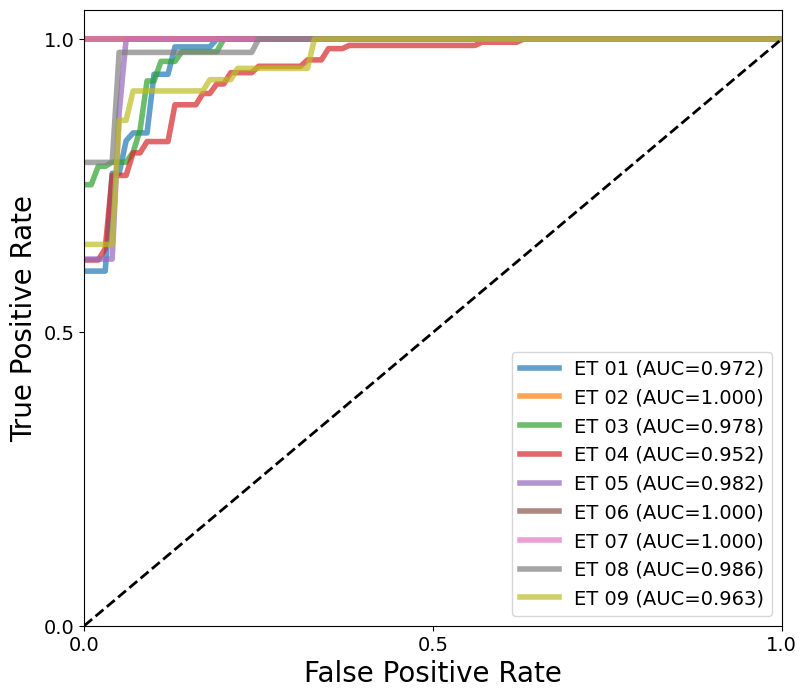

Generating Plot 2: Single Model (All Patients)...


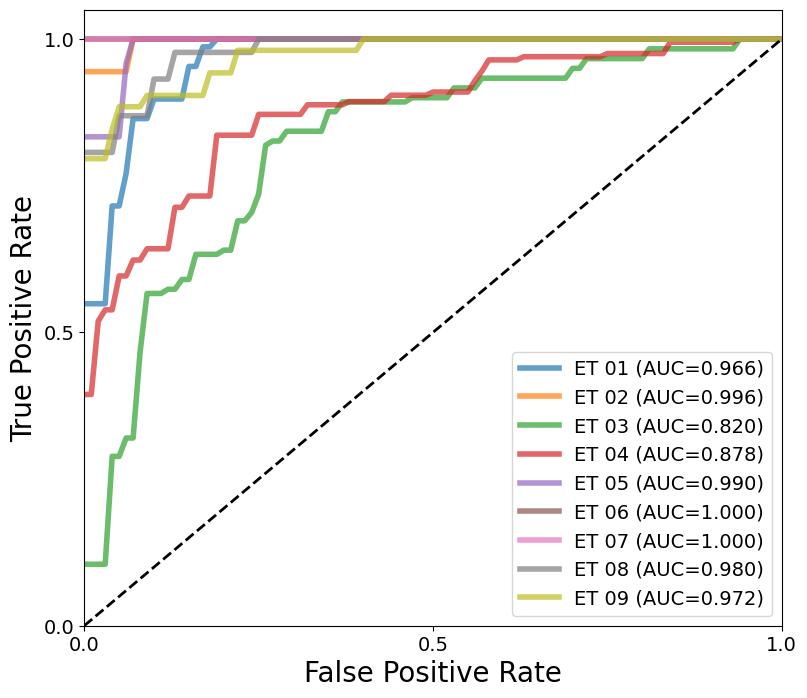

In [ ]:
# --- 4. (!!) NEW: 최종 플롯 생성 ---

# --- 플롯 1: MultiModal (모든 환자) ---
print("Generating Plot 1: MultiModal (All Patients)...")
plt.figure(figsize=(9, 8))
all_aucs_multi = []
for res in multi_model_roc_results:
    plt.plot(res['fpr'], res['tpr'],
             label=f"ET 0{res['patient_id']} (AUC={res['auc']:.3f})",
             lw=4, alpha=0.7)
    all_aucs_multi.append(res['auc'])

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks([0, 0.5, 1.0], fontsize=14)
plt.yticks([0, 0.5, 1.0], fontsize=14)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(loc="lower right", fontsize=14)
plt.savefig('/content/drive/MyDrive/MS/ETAnalysis/figure/figure_3_a_macro_average_ROC_curve_multi.png')
plt.show()


# --- 플롯 2: Single Model (모든 환자) ---
print("Generating Plot 2: Single Model (All Patients)...")
plt.figure(figsize=(9, 8))
all_aucs_multi = []
for res in single_model_roc_results:
    plt.plot(res['fpr'], res['tpr'],
             label=f"ET 0{res['patient_id']} (AUC={res['auc']:.3f})",
             lw=4, alpha=0.7)
    all_aucs_multi.append(res['auc'])

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks([0, 0.5, 1.0], fontsize=14)
plt.yticks([0, 0.5, 1.0], fontsize=14)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(loc="lower right", fontsize=14)
plt.savefig('/content/drive/MyDrive/MS/ETAnalysis/figure/figure_3_b_macro_average_ROC_curve_single.png')
plt.show()